<a href="https://colab.research.google.com/github/Lewis34cs/cloudy-lungs/blob/main/pneumonia_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4 Project

Chris Lewis

Contact: lewis34cs@gmail.com

Date: 12-8-2020

link to GitHub Repo: https://github.com/Lewis34cs/cloudy-lungs


### Introduction 

The goal of this project is to be able to produce a model that can identify whether or not a pedriatric patient has pneumonia based off of their chest x-ray image with an accuracy greater than 90%. 

 Our data was gathered from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

While chest x-rays are the primary source of diagnosis for this disease, it can still be difficult even for an experienced and well trained radiologist to correctly detect pneumonia with their eyes alone. 

### Our Flow
We begin by importing the data into our google drive, redefining our validation data to an amount we see fit, and then creating a baseline model to determine what our "floor" accuracy is. From there, we create our first basic CNN model, and then augment our training data to allow our models to have "more" data to train on. Afterwards, we create our class weights and implement them into our models, increase model complexity and explore different options in terms of our model's parameters. Finally, we introduce Transfer Learning and create a top layer function for several transfer models which we then train and evaluate.  

# Obtain

https://drive.google.com/file/d/1eZi6nDlvgVsdlN6HRpKj6H-YMJMF6ZLB/view?usp=sharing

### Mounting our google drive and viewing the GPU

In [ ]:
# We must run this in order for colab to be able to access our google drive

from google.colab import drive
drive.mount('/content/drive') #, force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Allows us to see the type of GPU we are given

# Because we have Google Pro, we are given a better GPU to work with, which means
# we are able to do everything at a faster pace than those with no Google Pro subscription.
# We can verify this by taking a look at the GPU we are given below.

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Dec  9 18:24:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing Libraries

In [ ]:
#Setting seeds first in order to achieve better consistency in scoring
import numpy as np
import tensorflow as tf

np.random.seed(321)
tf.random.set_seed(321)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys, glob, shutil
import datetime as dt
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
import time
from IPython.display import Image, display
from PIL import Image as Im

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.applications import VGG19, InceptionV3, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

### Defining Train, Test, and Validation Sets

#### Viewing our file location

In [ ]:
os.path.abspath(os.curdir)

'/content'

In [ ]:
# Changing to root directory so we can access the correct files
%cd ~
%cd ..

/root
/


In [ ]:
def folder_contents(source_folder=os.path.abspath(os.curdir)): # '/content/drive/My Drive'):
    """
    Definition:
    Displays the contents within a source folder.

    Parameter:
    source_folder: default = os.path.abspath(os.curdir) -- when a folder is set to
    this parameter, the function will display everything within that folder.

    Returns:
    Prints the address of the source_folder and displays the contents within.
    """

    print(f"Contents of {source_folder}:\n")
    display(sorted(os.listdir(source_folder)))

In [ ]:
folder_contents('/content/drive/My Drive')

Contents of /content/drive/My Drive:



['CVD Classification.gslides',
 'Colab Notebooks',
 'Copy of Thrombosis: Prevention by Slidesgo.gslides',
 'Getting started.pdf',
 'King County Presentation.gslides',
 'Microsoft Movies.gslides',
 'archive.zip',
 'gdrive',
 'pneumonia_proj.gslides']

#### Unzipping the target file from our google drive

Since our target folder in google drive is in a zipped folder (target folder name = 'archive.zip'), we have to manually unzip the folder in order to retrieve our dataset. The cell below does just this for us. If we unzipped the folder before loading it into our google drive, it would take much longer for google colab to process the data within. By unzipping it within google colab, we are saving a significant amount of time.

In [ ]:
# file source copied from left side of screen
# change the zipped_folder variable to match your filepath to access data
start = time.time()
zipped_folder = '/content/drive/My Drive/archive.zip'

fname = zipped_folder.split('/')[-1]

# Copying and unzipping the targeted file
!cp "{zipped_folder}" .
!unzip -q "{fname}" 
!rm "{fname}"
end = time.time()
print(f"Total time to run this cell: {round((end - start) / 60, 2)} minutes")

Total time to run this cell: 1.33 minutes


After unzipping the folder, the contents within that folder can now be seen by using our `folder_contents()` function.

# Exploring and Scrubbing

Since the images were initially screened for quality control by removing all low quality or unreadable scans and then graded by two expert physicians before being cleared for training the AI system, along with accounting for any grading errors by using a third expert to check the previous two experts' gradings, we don't need to worry too much about any errors within the file itself. Our primary concern will be making sure the train, test, and validation folders are stocked with an appropriate amount of images.

In [ ]:
folder_contents()

Contents of /:



['.dockerenv',
 'bin',
 'boot',
 'chest_xray',
 'content',
 'datalab',
 'dev',
 'etc',
 'home',
 'lib',
 'lib32',
 'lib64',
 'media',
 'mnt',
 'opt',
 'proc',
 'root',
 'run',
 'sbin',
 'srv',
 'swift',
 'sys',
 'tensorflow-1.15.2',
 'tmp',
 'tools',
 'usr',
 'var']

Our target file is the 'chest_xray' file.

#### Defining and viewing the number of images within our train, test, and validation subfolders.

In [ ]:
base_folder = 'chest_xray/'
folder_contents(base_folder)

Contents of chest_xray/:



['__MACOSX', 'chest_xray', 'test', 'train', 'val']

Out of the subfolders within our 'chest_xray' file, we only want the 'test', 'val', and 'train' subfolders.

In [ ]:
train_folder = base_folder + 'train/'
test_folder = base_folder + 'test/'
val_folder = base_folder + 'val/'

In [ ]:
# Here we are saying "for every folder within this list of folders, 
# print the contents for each folder"
for  folder in [train_folder, test_folder, val_folder]:
  folder_contents(folder)
  print('\n')

Contents of chest_xray/train/:



['NORMAL', 'PNEUMONIA']



Contents of chest_xray/test/:



['NORMAL', 'PNEUMONIA']



Contents of chest_xray/val/:



['NORMAL', 'PNEUMONIA']

In [ ]:
def num_images(folder, targets=['NORMAL/', 'PNEUMONIA/']):
  """
  Definition:
  Adds up the number of files within each target folder and prints out the target
  folder name along with the total number of images in the folder. Also prints 
  the folder's directory path.

  Args:
  folder: Requires a filepath
  targets: default = ['NORMAL/', 'PNEUMONIA/']. Specify the target
  folders you wish to see how many files are contained within each.

  Returns:
  Prints out directory path, target folder names, and total number of images
  within each folder. Returns the num_images variable.
  """
  num_images = 0
  # Printing the folder address we are targeting
  print(folder)
  # the target is each subfolder within our folder 
  # (the default is NORMAL and PNEUMONIA)
  for target in targets:
      # counts the number of images within each target
      num_in_target = len(os.listdir(folder+target))
      # add the total number of images for each folder
      num_images += num_in_target
      print(f"Number of images in {target}: {num_in_target}")
  print(f"Total number of images: {num_images}")
  return num_images

In [ ]:
for  folder in [train_folder, test_folder, val_folder]:
  num_images(folder)
  print('\n')

chest_xray/train/
Number of images in NORMAL/: 1341
Number of images in PNEUMONIA/: 3875
Total number of images: 5216


chest_xray/test/
Number of images in NORMAL/: 234
Number of images in PNEUMONIA/: 390
Total number of images: 624


chest_xray/val/
Number of images in NORMAL/: 8
Number of images in PNEUMONIA/: 8
Total number of images: 16




Within our three folders, we see that our train folder contains 5216 images, our test folder contains 624 images, and our validation folder contains 16 images.

While 16 images to use as our validation set is better than nothing, we would prefer to have more images to validate our model with (preferably an 80/20 split between our test set and validation set). 

So we are going to take the NORMAL validation images from `chest_xray/val/NORMAL/` and move those into our `chest_xray/test/NORMAL/` folder, and do the same thing with the PNEUMONIA validation images and place them in our PNEUMONIA test folder. After that, we can set, split, and create our own validation set.

#### Absorbing validation folder images into our test folder images

In [ ]:
# Viewing the contents within our validation NORMAL and PNEUMONIA folders
folder_contents(val_folder)
print('\n')
val_normal = val_folder + 'NORMAL/'
val_pneumonia = val_folder + 'PNEUMONIA/'
folder_contents(val_normal)
print()
folder_contents(val_pneumonia)

Contents of chest_xray/val/:



['NORMAL', 'PNEUMONIA']



Contents of chest_xray/val/NORMAL/:



['NORMAL2-IM-1427-0001.jpeg',
 'NORMAL2-IM-1430-0001.jpeg',
 'NORMAL2-IM-1431-0001.jpeg',
 'NORMAL2-IM-1436-0001.jpeg',
 'NORMAL2-IM-1437-0001.jpeg',
 'NORMAL2-IM-1438-0001.jpeg',
 'NORMAL2-IM-1440-0001.jpeg',
 'NORMAL2-IM-1442-0001.jpeg']


Contents of chest_xray/val/PNEUMONIA/:



['person1946_bacteria_4874.jpeg',
 'person1946_bacteria_4875.jpeg',
 'person1947_bacteria_4876.jpeg',
 'person1949_bacteria_4880.jpeg',
 'person1950_bacteria_4881.jpeg',
 'person1951_bacteria_4882.jpeg',
 'person1952_bacteria_4883.jpeg',
 'person1954_bacteria_4886.jpeg']

In [ ]:
def image_move(source='', move=''):
  """
  Definition:
  Takes files from the source variable and transports them into the move variable.

  Args:
  source: default = ''. The file you want to move items from.
  move: default = ''. The file you want to move items to.

  Returns:
  A print statement if source or move variables are not specified. Otherwise, it
  does not return anything.
  """
  
  if len(source) > 0:
    target_files = []
    #Appending the images within the 'source' folder to a list called target_files
    for file in os.listdir(source):
      target_files.append(file)
  else:
    print('You must provide a source location!')
  if len(move) > 0:
    #Using shutil, we move the images from the source directory into the selected
    #variable defined as 'move'.
    for f in target_files:
      shutil.move(source+f, move)
  else:
    print('You must provide the directory location for the files to go!')


In [ ]:
# moving images from our NORMAL file in val to our NORMAL file in test
image_move(source=val_normal, 
           move='/chest_xray/test/NORMAL')

In [ ]:
# moving images from our PNEUMONIA file in val to our PNEUMONIA file in test
image_move(source=val_pneumonia, 
           move='/chest_xray/test/PNEUMONIA')

#### Setting batch sizes for our train, test, and val sets

## EXPLAIN WHAT IS HAPPENING - calculating set sizes, etc

In [ ]:
# Here we are setting the size for our train size and our test/val size
# We are doing this because we are going to set these values as the batch sizes
# for our ImageDataGenerator.flow_from_directory(), so it will spit out the 
# entire train, test, and val sets instead of the default 32 batch size.
# This allows us to bypass the need to use a generator when fitting our models.
TRAIN_BATCH_SIZE = num_images(train_folder)
TEST_VAL_BATCH_SIZE = num_images(test_folder)

VAL_SPLIT = 0.2
TEST_BATCH_SIZE = round((1-VAL_SPLIT) * TEST_VAL_BATCH_SIZE)
VAL_BATCH_SIZE = round(VAL_SPLIT * TEST_VAL_BATCH_SIZE)
print()
print(f"Train batch size: {TRAIN_BATCH_SIZE}\nTest batch size: {TEST_BATCH_SIZE}")
print(f"Val batch size: {VAL_BATCH_SIZE}")

chest_xray/train/
Number of images in NORMAL/: 1341
Number of images in PNEUMONIA/: 3875
Total number of images: 5216
chest_xray/test/
Number of images in NORMAL/: 242
Number of images in PNEUMONIA/: 398
Total number of images: 640

Train batch size: 5216
Test batch size: 512
Val batch size: 128


Now that we've successfully moved our images into the correct folders, we can create ImageDataGenerators to have our data flow from these generators. We can take advantage of the Datagenerators by specifiying our batch sizes to be equal to the number of images in their respective folders!


In [ ]:
# Setting the image size to 256 x 256 pixels
IMG_SIZE = (256, 256)

We've set our image size to be quite large, but this will give our model more pixels == more data to look at. Notice below we are rescaling both of the ImageDataGenerators by `1./255`. The denominator (255) is not a random number, it is the maximum value of pixel intensity in an image, regardless of color. Also notice our numerator - we've put a 1 with a decimal. This means that the output will be a float. So by doing this, all our pixel values will be within a range of 0 to 1.

Since we are no longer using our validation folder as a source to gather data from, notice the `test_val_datagen` variable. Within this variable, we've set the parameter called `validation_split` equal to `VAL_SPLIT`. What this does is it allows us to generate our own validation set from a percentage (VAL_SPLIT) of our test set. We've defined our `VAL_SPLIT = 0.2`

In [ ]:
#Creating Image Data Generators without any augmentation
train_datagen = ImageDataGenerator(rescale = 1./255)
test_val_datagen = ImageDataGenerator(rescale = 1./255, 
                                      validation_split=VAL_SPLIT)

By setting the `batch_size` of the DataGenerators to the total number of data for train, test, and validation, (5216, 512, and 640 respectively) we can create our train, test, and validation sets from these generators!

Our `class_mode = 'binary'` because we are dealing with a binary classification task. Notice within the test_set_full and val_set_full variables there is another parameter we've set called `subset`. 

test_set_full is considered the `'training'` subset while val_set_full is the `'validation'` subset. This is merely because we are pulling out a percentage of the test data to use as our validation data. 

In [ ]:
# Creating our datasets from our defined DataGenerators
train_set_full = train_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=TRAIN_BATCH_SIZE,
                                                   class_mode='binary')

test_set_full = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=TEST_BATCH_SIZE,
                                                     class_mode='binary', 
                                                     subset='training')

val_set_full = test_val_datagen.flow_from_directory(test_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=VAL_BATCH_SIZE,
                                                    class_mode='binary', 
                                                    subset='validation')

Found 5216 images belonging to 2 classes.
Found 513 images belonging to 2 classes.
Found 127 images belonging to 2 classes.


In [ ]:
# Viewing our classes within the train set
train_set_full.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Now we will define our train, test, and validation sets by using the `next()` function on our ImageDataGenerators. Since we specified the `batch_size` as the total number of images for each of the sets, the ImageDataGenerators will pass through all images into our respective sets.

In [ ]:
start = time.time()
# Creating X and y values for train, test, and validation sets
X_train, y_train = next(train_set_full)
X_test, y_test = next(test_set_full)
X_val, y_val = next(val_set_full)
end = time.time()
print(f"Total time to run this cell: {round((end - start) / 60, 2)} minutes")

Total time to run this cell: 1.04 minutes


##RECOMMENDATION:

It is extremely important to set appropriate sizes for train, test, and validation sets. While we received a validation set with only 16 images to test on, we managed to increase our validation's size significantly which will allow us to better identify how well our model is performing in terms of certain scoring (which we will define later on).

In [ ]:
# We will save this shape to later insert into our model as the input shape
INPUT_SHAPE = X_train.shape[1:]
print(INPUT_SHAPE)

(256, 256, 3)


In [ ]:
def random_image(X, y):
  """
  Definition:
  Selects a random number (i) within the range of the length of X. Then prints 
  the class label associated with that random number (i) along with the image
  associated with the specific X[i] array.

  Args:
  X: an np.array
  y: labels associated with the np.array

  Returns:
  Prints the class along with the y label, and displays the randomly selected image.
  """
  # Getting a random number within the range of our X variable
  i = np.random.choice(range(len(X)))
  # Determining what the label is and printing appropriate class
  if y[i] == 0:
    print(f"Normal Class --> {y[i]}")
  else:
    print(f"Pneumonia Class --> {y[i]}")
  # Displaying the image
  display(array_to_img(X[i]))

Pneumonia Class --> 1.0


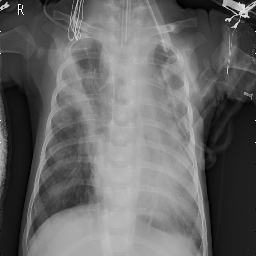

In [ ]:
random_image(X_train, y_train)

In [ ]:
def count_class(y):
  """
  Definition:
  Turns our y-label into a series, then plots the count of our y-series value
  counts. 

  Args:
  y: Requires a y-label.

  Returns:
  Plots the count of the y-label series values
  """
  with plt.style.context('seaborn'):
    fig, ax = plt.subplots()
    # Making our y variable into a Series type so we can call .value_counts()
    # and then plot the counts for each class
    ax = pd.Series(y).value_counts().plot(kind='barh', color=['red', 'green'])
    ax.set_ylabel('Classes', fontsize=15)
    ax.set_title('Normal = 0.0        Pneumonia = 1.0', fontsize=20)
    ax.set_xlabel('Count',fontsize=15)
    plt.show()

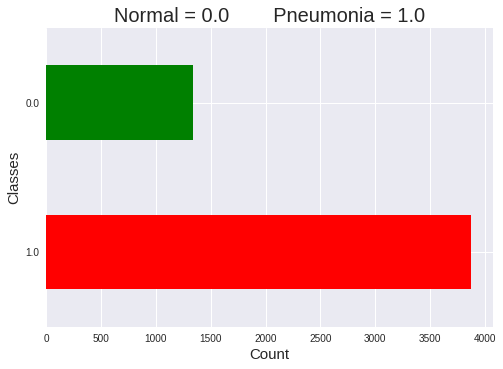

In [ ]:
count_class(y_train)

Above we can see that within our dataset, our classes are not balanced. Here we see that there are more images classified as having '**pneumonia**' when compared to those classifed as '**normal**'. This is not uncommon in the medical field, and there are some techniques that we can utilize to help prevent this imbalance from skewing our results. 

### Creating Baseline Model

Because our classes are imbalanced, we will be using the balanced_accuracy_score with a dummy classifier.

According to sklearn, "The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class."

In the medical field, depending on the circumstances and the severity of the disease/infection, will determine whether we want to avoid false positives or false negatives more. 

for example: say a person has skin cancer but doesn't know it, and is going in to get tested. The doctor takes a few pictures of potentially malignant melonamas and then feeds it into our model. If our model has relatively great accuracy but not so great recall, it may tell the person they do not have a malignant when in fact they do. This is a false negative, and can be dangerous in that type of circumstance because the patient was misdiagnosed, and now the melanoma may spread to other organs before they get tested again.

By setting our dummy classifier to calculate the average recall for each class, we are avoiding the false negatives and false positives equally. 

## ADD A CONFUSION MATRIX

              precision    recall  f1-score   support

         0.0       0.37      0.26      0.31       193
         1.0       0.62      0.73      0.67       319

    accuracy                           0.55       512
   macro avg       0.49      0.50      0.49       512
weighted avg       0.53      0.55      0.53       512

Balanced accuracy score of our dummy classifier: 49.58%


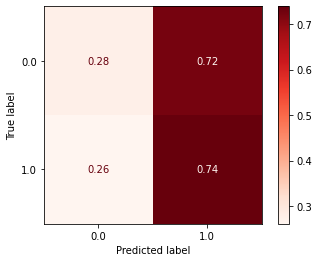

In [ ]:
from sklearn.metrics import balanced_accuracy_score

# Creating and fitting our dummy classifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

# Creating our y_pred variable
y_pred = dummy.predict(X_test)

#Printing classification report and plotting confusion matrix
print(metrics.classification_report(y_test, y_pred))
metrics.plot_confusion_matrix(dummy, X_train, y_train, normalize='true', cmap='Reds')
score = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy score of our dummy classifier: {(score*100):.2f}%")

Our dummy classifier had a balanced accuracy score of about 50% when it came to classifying chest xray images correctly.

# Modeling

For our first model, we won't be doing anything too complex. We are going to define a function that creates a Sequential model, add 3 layers to it, and then define its output layer. 

The metrics we will want to look at will be: accuracy, precision, and recall. Loss will also be included, but we do not need to define it within the metrics parameter.

-------------------------------------------------------------------
**Accuracy** is the ratio of all correct predictions divided by all predictions our model has made, both correct and incorrect. 

(TP + TN) / (TP + TN + FP + FN)

While this is generally a good metric to look at, we need to be careful because our dataset is unbalanced. We could achieve a better accuracy score than our Dummy Classifier if our model were to only guess the majority class.

-------------------------------------------------------------------
**Precision** is the ratio of True Positives divided by all predicted positives. TP / (TP + FP)

Precision allows us to answer "Out of all the images marked positive, how many are actually positive?" 

-------------------------------------------------------------------
**Recall** is the ratio of True Positives divided by all actual positives. TP / (TP + FN)

Recall allows us to answer "Out of all the images marked positive, how many images were correctly marked positive?"



In [ ]:
def create_basic_cnn(shape='',
                     metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')]):
  """
  Definition:
  Creates a basic cnn model consisting of three layers and an output layer.

  Args:
  shape: this function requires an input shape in order for the model to be created.

  Returns:
  Returns a compiled model.
  """
  # We are requiring an input shape since we print the model.summary() at the 
  # end of the function
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    # Input layer
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))

    # Second layer
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
      
    # Third layer
    model.add(Flatten())
    model.add(layers.Dense(128, activation='relu'))
      
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())
    return model

Setting up functions to allow us to run through models without many lines of code each time.

In [ ]:
def plot_history(history, metric_list=['acc', 'loss', 'precision', 'recall']):
  """
  Definition:
  Creates a dataframe with a model.history variable. Then plots columns within the 
  dataframe if the column contains a metric within the metric list.

  Args:
  history: requires a model.history variable.
  metric_list: default = ['loss', 'acc']. Based on the metric's used in the model's 
  compiled metrics. 

  Returns:
  plots the columns that contain the metric within the metric list
  """
  # creating a dataframe of the model.history variable
  history_df = pd.DataFrame(history.history)

  with plt.style.context('seaborn'):    
    for metric in metric_list:
      history_df[[col for col in history_df.columns if metric in col]].plot(figsize=(8, 4), 
                                                                            marker='o')

      # Setting the title for each plot to be be the focused metric
      plt.title(metric.title())
      plt.grid(True)
      #sets the vertical range to [0-1]
      plt.gca().set_ylim(0, 1)
    plt.show()

In [ ]:
def class_report(model,X_test,y_test, class_indices=train_set_full.class_indices):
  """
  Definition:
  Prints out a classification report by predicting y_pred using model.predict() 
  and plots a heatmap of a confusion matrix using seaborn's heatmap() function. 

  Args:
  model: Requires a model.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  class_indices: default = train_set_full.class_indices. Pass through a dictionary
  that defines the classes. Must match up with the y_test labels.

  Returns:
  Prints out a classification report and a confusion matrix.  
  """
    
  # creating a title using the class_indices.items()
  title = ''
  for key, val in class_indices.items():
        title += key + ' = ' + str(val) + '    '
    
  # defining our prediction and rounding since we are dealing with binary classification
  y_pred = model.predict(X_test)
  y_pred = y_pred.round()

  # Printing a classification report to see accuracy, recall, precision, f1-score
  dashes = '---'*19
  print(dashes)  
  print('                  Classification Report\n')
  print(metrics.classification_report(y_test, y_pred))
  print(dashes)
    
  # plots a normalized confusion matrix
  conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  ax = sns.heatmap(conf_mat, cmap='Reds', annot=True, square=True)
  ax.set(xlabel='Predicted Class', ylabel='True Class')
  ax.set_ylim(2, 0)
  ax.set(title=title)
  plt.show()

In [ ]:
def fit_cnn(model, X_train, y_train, X_val, y_val, X_test, y_test, 
            epochs=10, batch_size=32, plot_hist=1):
  """
  Definition:
  Fits a passed in model saved in a variable 'history'. Then activates the 
  class_report function which returns a classification report and a confusion
  matrix. Finally, plots the history using the plot_history() function.

  Args:
  model: Requires a model.
  X_train: Requires a train set of features.
  y_train: Requires a train set of labels.
  X_val: Requires a validation set of features.
  y_val: Requires a validation set of labels.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  epochs: default = 10. Defines the number of passes the ML algorithm will complete.
  batch_size: default = 32. Defines the number of training examples utilized in
  one iteration before updating internal parameters.
  plot_hist: default = 1. Defines whether or not the plot_history() function will
  be executed. 

  Returns:
  history, prints classification report, confusion matrix, and plots history metrics.
  """
  start = time.time()
  # fitting our model and storing results in our history variable
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
             validation_data=(X_val, y_val))
  
  # Calling our class_report() func  
  class_report(model, X_test, y_test)
    
  if plot_hist:
      # Calling our plot_history() func
      plot_history(history) 

  # Printing out each metric score and total time
  dashes = '---'*20
  print(dashes)
  eval_scores = model.evaluate(X_test, y_test)
  metric_list=['loss', 'accuracy', 'precision', 'recall']
  for i, score in enumerate(eval_scores):
    print(f"{metric_list[i]} score: {score}")

  end = time.time()
  print(f"\nTotal time to complete: {round((end-start)/60, 2)}minutes")
  return history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               31490176  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

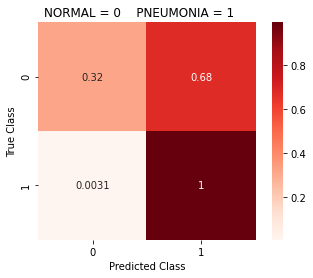

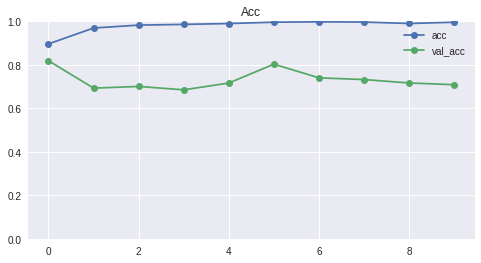

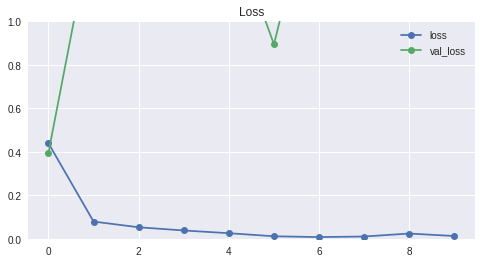

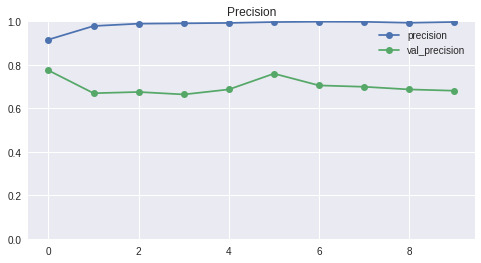

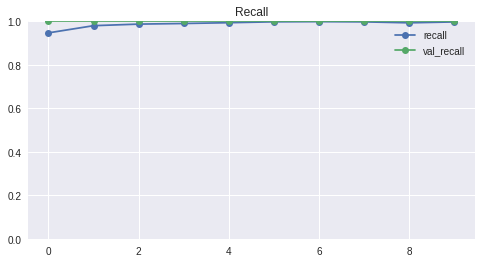

------------------------------------------------------------
16/16 [==============================] - 0s 15ms/step - loss: 2.6906 - acc: 0.7422 - precision: 0.7082 - recall: 0.9969
loss score: 2.6906497478485107
accuracy score: 0.7421875
precision score: 0.7082405090332031
recall score: 0.9968652129173279

Total time to complete: 1.06minutes


In [ ]:
cnn01 = create_basic_cnn(shape=INPUT_SHAPE)
history01 = fit_cnn(cnn01, X_train, y_train, X_val, y_val, X_test, y_test, epochs=10)

As we can see in our metric plots, our model seemed to be overfitting with the training data. We saw before that there is unbalance between those with and without pnemonia, with the majority of these images being classified as having pneumonia. Our model does extremely well at classifying those with pneumonia, but we also see an extremely high false positive rate of about 70% when trying to classify images without pneumonia. So if we were to use this model to diagnose pneumonia, if an image was determined to have 'Normal', our model would have correctly classified that around 99% of the time. However, if an image was determined to have 'Pneumonia', that may or may not be the case due to the high amount of false positives.

While we did achieve an accuracy of 73.7% with our test data and had a loss of 2.92, we will try to improve our model's ability to classify through data augmentation. 

*(Note that because we are using google colab, the results will never be the exact same every time this notebook is run).

### Augmenting our training data

We will now augment the training data within ImageDataGenerators in new variables called 'basic_aug_train_datagen' and 'aug_train_datagen'.

By implementing arguments like rotation_range, zoom_range, and horizontal_flip, we give our model more to look at, even though there are no actual new images being generated. Instead, these augments are just randomly shifting, flipping, zooming, shearing, etc. around the image data within our training set. We are choosing to augment our data because we don't have much data to work with. By augmenting the data, we are giving our model more to look at without actually providing any new data. However, we cannot pull off that trick we used earlier to create X and y variables. Now we must use our generators to create models instead of only passing in X and y variables.

It is important to note that we should NEVER augment our test or validation data. 

In [ ]:
# Creating an ImageDataGenerator that contains 3 augmentations
basic_aug_train_datagen = ImageDataGenerator(rotation_range=45, 
                                             zoom_range=0.2,
                                             horizontal_flip=True)

The generator below will be used later on in the project.

In [ ]:
# Creating an ImageDataGenerator that contains more augmentations
aug_train_datagen = ImageDataGenerator(rotation_range=45, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True)

Storing pictures of our augmented data in the below address so we can physically view the augmentations

In [ ]:
# Creating the address to store our augmented pictures so we can view them
pic_folder = '/content/drive/MyDrive/gdrive/pics/pneumo_aug_imgs/'
os.makedirs(name=pic_folder,exist_ok=True)

In [ ]:
#Saving augmented pics from our aug_train_datagen into the folder above
run = 1
i = 1
if run:
  folder_count = len(os.listdir(pic_folder))
  if folder_count < 32:
    for batch in aug_train_datagen.flow(X_train, y_train, save_to_dir=pic_folder, 
                                        batch_size=1):
      if i >= 32 - folder_count:
        break
      else:
        i+=1

In [ ]:
# Making sure the right number of pictures have been saved
len(os.listdir(pic_folder))

32

In [ ]:
def display_images(source, amnt_to_display):
  """
  Definition:
  Define the 'source' variable by giving it a filepath containing images along with
  setting the number you wish to view through the variable 'amnt_to_display'. The
  function will plot the selected number of images within the file and display them.

  Args:
  source: Required. A filepath containing images.
  amnt_to_display: Required. The number of images you wish to display.

  Returns:
  Plots a certain amount of images from the selected filepath.
  """
  
  plt.figure(figsize=(15,10))
  cols = amnt_to_display//2
  images = os.listdir(source)[:amnt_to_display]
  for i, img in enumerate(images):
      #Opening each image from its respective filepath
      x_image = Im.open(source+img)
      # defining the position for each subplot 
      # subplot(nrows, ncols, index)
      plt.subplot(len(images) / cols + 1, cols, i + 1)
      #plotting each image in a new subplot
      plt.imshow(x_image)
      # Hiding the x and y axis tick marks
      plt.xticks([])
      plt.yticks([])
      # fitting the images closer together
      plt.tight_layout()

Now we can view our augmented pictures to see what the augmentation is doing

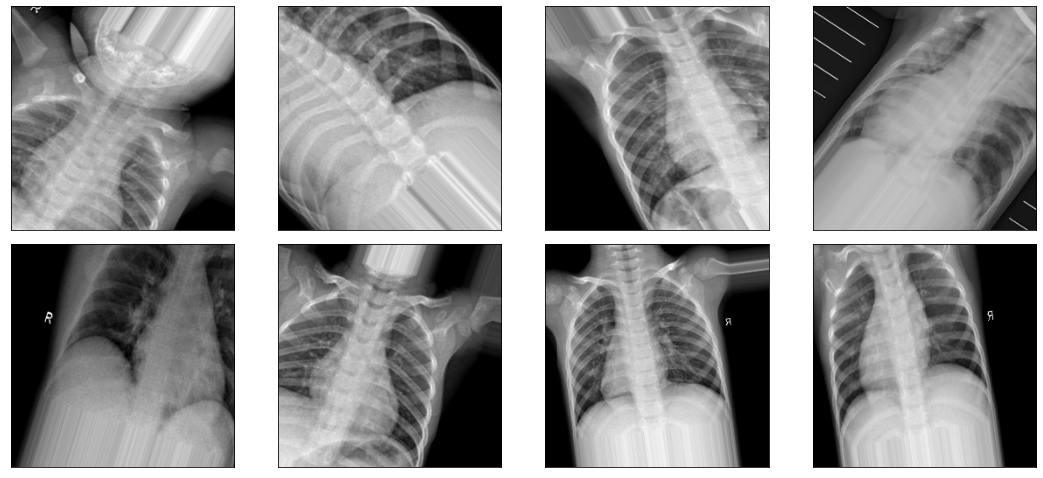

In [ ]:
display_images(pic_folder, 8)

Above we can physically see that our aug_train_datagen is augmenting our pictures. 

Now we will implement our datagenerator to feed in the images into our `model.fit()` function by building off of our `fit_cnn()` function, creating a new function called `fit_cnn_gen()`.

In [ ]:
# Same function as our fit_cnn(), only we make the data flow from our generator
def fit_cnn_gen(model, X_train, y_train, X_val, y_val, X_test, y_test,
                generator, epochs=10, batch_size=32, plot_hist=1):
  """
  Definition:
  Fits a passed in model saved in a variable 'history'. Then activates the 
  class_report function which returns a classification report and a confusion
  matrix. Finally, plots the history using the plot_history() function.

  Args:
  model: Requires a model.
  X_train: Requires a train set of features.
  y_train: Requires a train set of labels.
  X_val: Requires a validation set of features.
  y_val: Requires a validation set of labels.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  epochs: default = 10. Defines the number of passes the ML algorithm will complete.
  batch_size: default = 32. Defines the number of training examples utilized in
  one iteration before updating internal parameters.
  plot_hist: default = 1. Defines whether or not the plot_history() function will
  be executed. 
  generator: default = 0. If using a generator to augment training data, this 
  variable will use the .flow() function to gather data from X_train and y_train 
  to augment the training data. 

  Returns:
  history, prints classification report, confusion matrix, and plots history metrics.
  """
  start = time.time()
  history = model.fit(generator.flow(X_train, y_train, batch_size=batch_size), 
                                  validation_data=(X_val, y_val),  
                                  epochs=epochs)
      
  class_report(model, X_test, y_test)
    
  if plot_hist:
      plot_history(history) 
  
  dashes = '---'*20
  print(dashes)
  eval_scores = model.evaluate(X_test, y_test)
  metric_list=['loss', 'accuracy', 'precision', 'recall']
  for i, score in enumerate(eval_scores):
    print(f"{metric_list[i]} score: {score}")
    
  end = time.time()
  print(f"\nTotal time to complete: {round((end-start)/60, 2)}minutes")
  return history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               31490176  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

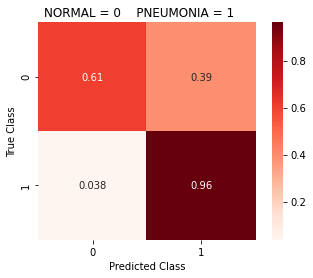

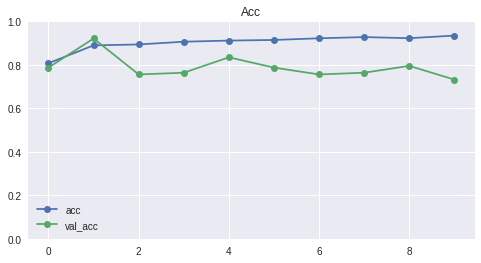

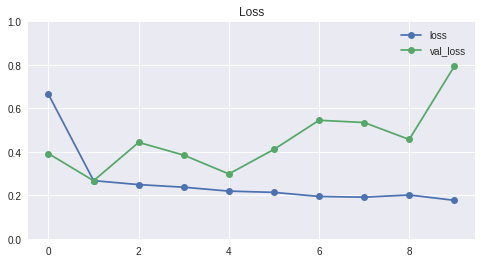

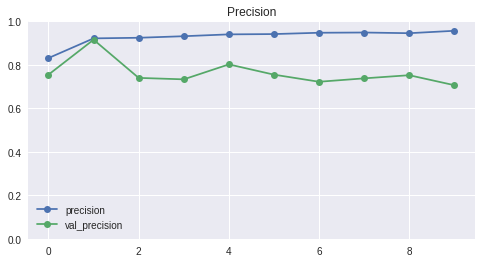

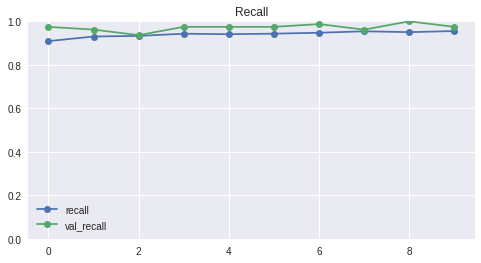

------------------------------------------------------------
16/16 [==============================] - 0s 14ms/step - loss: 0.5819 - acc: 0.8281 - precision: 0.8016 - recall: 0.9624
loss score: 0.5818932056427002
accuracy score: 0.828125
precision score: 0.8015666007995605
recall score: 0.962382435798645

Total time to complete: 10.47minutes


In [ ]:
cnn02 = create_basic_cnn(shape=INPUT_SHAPE)
history02 = fit_cnn_gen(cnn02, X_train, y_train, X_val, y_val, X_test, y_test, 
                    generator=basic_aug_train_datagen)

>So our newer model definitely shows improvement when compared to our first model, which means augmenting our training data using an Image Data Generator did indeed help the model in identifying the correct class for each image. However, notice that it took much more time to train our model when using our ImageDataGenerator to feed in the data. We may want to reduce the image size of our data later on if we want to decrease the amount of time it takes to run. 



###**RECOMMENDATION:**

If you are working with a small and/or unbalanced dataset, augmenting the training data can give your model 'more' to look at, and it can prevent any overfitting that may occur if our dataset is too small.

We can further improve (potentially) our model by increasing the complexity through more augmentation, adding more layers, adding different types of layers, adding neurons, including weights for classes, setting different batch sizes, changing optimizers, tuning learning rates, and using transfer learning models. 

### Computing the Weights for our Classes

The `class_weight.compute_class_weight()` func takes in three parameters:

1. class_weight: this parameter will accept a dictionary, the word 'balanced', or None. If using a dictionary it must be a dictionary containing defined class weights where the keys are the class names and the values are the respective weights. If 'balanced' is chosen, then the class weights will be given by the algorithm `n_samples / (n_classes * np.bincount(y))`. If None, then the class weights will be uniform. 

2. classes: this is where we pass in each class. We can do this by saying `np.unique(y_train)`. This will output our two classes: Normal and Pneumonia.

3. y: here we will pass in our y_train, which will give it all labels within our training set. This basically adds up how many samples we see for each class.

-----------------------------------------------------------------------------

The reason we want to add the weights as a parameter for our model is because we want to nullify as much of the class imbalance as we can. The weights influence the classification of our classes during our model's training. The goal of this is to penalize misclassification of the minority class by setting a higher weight and reducing the weight for the majority class. 

In [ ]:
# Putting our class weights into a dictionary so we can use them in our 
# fit_cnn_gen() func
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), 
                                                  y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Our class weights:\n{class_weights_dict}")

Our class weights:
{0: 1.9448173005219984, 1: 0.6730322580645162}


Restructuring our fit_cnn_gen() func to take in class_weights and feed it into the model.fit() func.

In [ ]:
# Including a class_weights parameter into our function
def fit_cnn_gen(model, X_train, y_train, X_val, y_val, X_test, y_test,
                generator, epochs=10, batch_size=32, plot_hist=1, 
                class_weights=None):
  """
  Definition:
  Fits a passed in model saved in a variable 'history'. Then activates the 
  class_report function which returns a classification report and a confusion
  matrix. Finally, plots the history using the plot_history() function.

  Args:
  model: Requires a model.
  X_train: Requires a train set of features.
  y_train: Requires a train set of labels.
  X_val: Requires a validation set of features.
  y_val: Requires a validation set of labels.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  generator: Specify a generator to augment training data, this 
  variable will use the .flow() function to gather data from X_train and y_train 
  to augment the training data. 
  epochs: default = 10. Defines the number of passes the ML algorithm will complete.
  batch_size: default = 32. Defines the number of training examples utilized in
  one iteration before updating internal parameters.
  plot_hist: default = 1. Defines whether or not the plot_history() function will
  be executed. 
  class_weights: default = None. Pass in a dictionary containing the class weights, 
  where the keys are the classes and the values are the weights.

  Returns:
  history, prints classification report, confusion matrix, and plots history metrics.
  """
  start = time.time()
  history = model.fit(generator.flow(X_train, y_train, batch_size=batch_size), 
                        validation_data=(X_val, y_val), 
                        epochs=epochs, class_weight=class_weights)
  
  class_report(model, X_test, y_test)
    
  if plot_hist:
      plot_history(history) 

  dashes = '---'*20
  print(dashes)
  eval_scores = model.evaluate(X_test, y_test)
  metric_list=['loss', 'accuracy', 'precision', 'recall']
  for i, score in enumerate(eval_scores):
    print(f"{metric_list[i]} score: {score}")

  end = time.time()
  print(f"\nTotal time to complete: {round((end-start)/60, 2)}minutes")
  return history

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               31490176  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

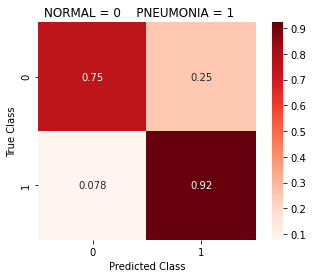

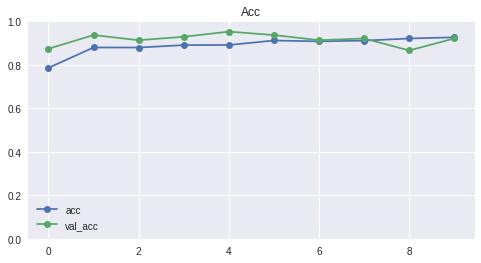

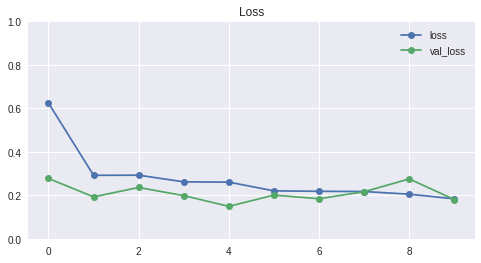

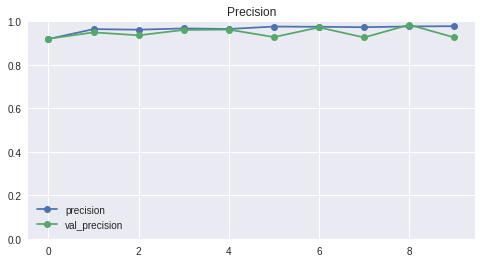

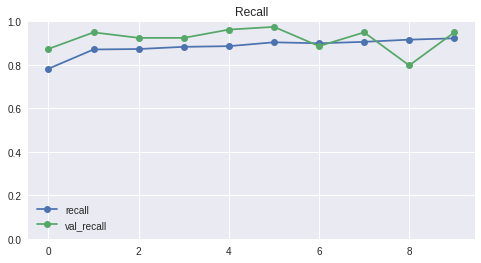

------------------------------------------------------------
16/16 [==============================] - 0s 14ms/step - loss: 0.3189 - acc: 0.8555 - precision: 0.8571 - recall: 0.9216
loss score: 0.3189418315887451
accuracy score: 0.85546875
precision score: 0.8571428656578064
recall score: 0.9216300845146179

Total time to complete: 10.19minutes


In [ ]:
cnn03 = create_basic_cnn(shape=INPUT_SHAPE)
history03 = fit_cnn_gen(cnn03, X_train, y_train, X_val, y_val, X_test, y_test, 
                        batch_size=32, generator=basic_aug_train_datagen,
                        class_weights=class_weights_dict)

##RECOMMENDATION:
"Class weights directly modify the loss function by giving more (or less) penalty to the classes with more (or less) weight. In effect, one is basically sacrificing some ability to predict the lower weight class (the majority class for unbalanced datasets) by purposely biasing the model to favor more accurate predictions of the higher weighted class (the minority class)."

(Retrieved from https://datascience.stackexchange.com/questions/52627/why-class-weight-is-outperforming-oversampling)

Here we can see that adding class weights into our function really helped out the training of our model. Our model is able to better differentiate between the NORMAL and PNEUMONIA classes, giving us better accuracy, precision, and our loss also decreased. I would recommend implementing class weights if a dataset's classes are unbalanced (not 50/50).

### Increasing the complexity of our model

We are going to begin to include more layers, along with Dropout layers to help reduce our model's tendency to overfit on the training data. However, if we make a model too complex, it could actually hinder our model's ability to classify images correctly. We will be including a dropout layer in the next model architecture - this layer ignores a random subset of units in a layer (sets the weights to 0) during each phase of training. This technique is effective because it allows us to train our neural networks on different parts of the data, which ensures that our model will not be overly sensitive to any noise in the data.

In [ ]:
# creating a new model that contains more layers and neurons, along with a
# Dropout layer
def create_improved_cnn(shape='', opt=tf.keras.optimizers.Adam(), 
                        metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')]):
    if len(shape) < 1:
      print('Please define input shape!')
    else:
      model = Sequential()
      model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
      model.add(MaxPooling2D((2, 2)))
      
      model.add(layers.Conv2D(64, (3,3), activation='relu'))
      model.add(MaxPooling2D((2, 2)))

      model.add(layers.Conv2D(128, (5, 5), activation='relu'))
      model.add(MaxPooling2D((4, 4)))
      
      model.add(Flatten())
      model.add(layers.Dense(512, activation='relu'))
      model.add(layers.Dropout(0.2))

      model.add(layers.Dense(256, activation='relu'))

      model.add(layers.Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
      print(model.summary())
      return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 128)       204928    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)            

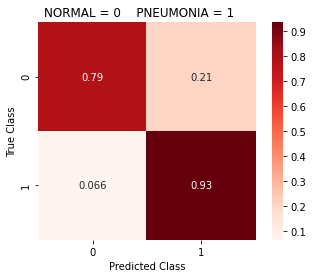

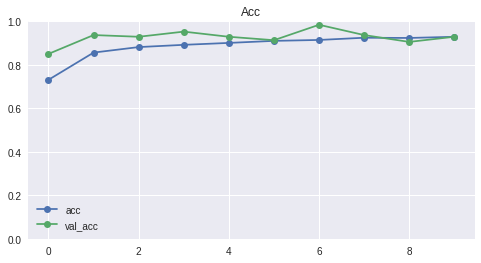

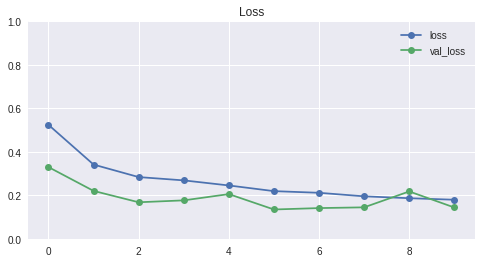

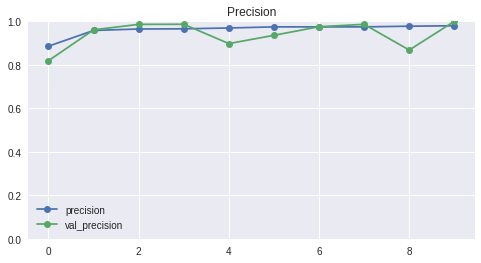

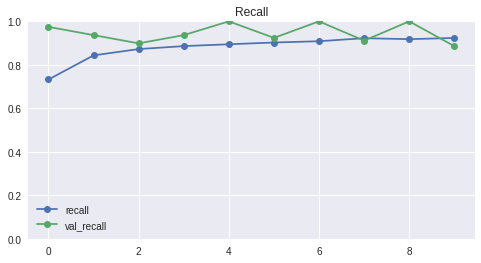

------------------------------------------------------------
16/16 [==============================] - 0s 16ms/step - loss: 0.3124 - acc: 0.8809 - precision: 0.8817 - recall: 0.9342
loss score: 0.31244057416915894
accuracy score: 0.880859375
precision score: 0.88165682554245
recall score: 0.9341692924499512

Total time to complete: 10.23minutes


In [ ]:
cnn04 = create_improved_cnn(shape=INPUT_SHAPE, 
                            opt=tf.keras.optimizers.Adam(learning_rate=0.001))
history04 = fit_cnn_gen(cnn04, X_train, y_train, X_val, y_val, X_test, y_test, 
                    epochs=10, batch_size=32, generator=basic_aug_train_datagen, 
                    class_weights=class_weights_dict)

## Making and Adding Callbacks

There are some callbacks that we will  instantiate and implement in order to make sure that our model doesn't overfit, and will allow us to save the model into a folder in our drive. The two callbacks that we will be focusing on will be ModelCheckpoint and EarlyStopping.

ModelCheckpoint is an object that we can instantiate in order to save a model based off of some parameters we set within the object. We can tell it where to save the model, when to save the model, the saving filter we want to use (eg. best only, all the models, etc.) and so on. 

EarlyStopping is an object that allows us to define parameters that tell the model to stop training in order to prevent overfitting. We can specify how early to stop it, what value to be looking for in order to dictate whether or not the model should stop, and whether or not we want to restore the best weights for the model if we think the model needs to reset to the previous best weights. 

It's easy to implement these into our model.fit() function; there is a parameter called 'callbacks' that can take in a list of callbacks. It's that easy.

In [ ]:
# Creating a file path where we can store our saved models 
fpath = '/content/drive/My Drive/gdrive/models/pneumonia_models/'

# the func os.makedirs() will make any and all filepaths that don't already exist
os.makedirs(fpath, exist_ok=True)

### Run fit_cnn_gen, make_callbacks, big_path here

In [ ]:
# Defining a new function to allow us to create and implement callbacks within
# our fit_cnn_gen() function
def make_callbacks(monitor='val_loss', min_delta=0, patience=0, mode='auto', 
                   f_path='/content/drive/My Drive/gdrive/models/pneumonia_models/', 
                   restore_best_weights=False, save_best_only=False, 
                   save_freq='epoch'):
  """
  Definition:
  Creates two variables, and then returns these variables in a list.

  1. variabel 'earlystop' stops model training when the 'monitor' metric has not 
  improved past the 'min_delta' threshold after a certain amount of epochs, 
  defined by 'patience'. 

  2. variable 'checkpoint' saves model at some interval, so the model can be 
  loaded later on to continue the training from the saved state.

  Args:
  monitor: default = 'val_loss'. Quantity to be monitored during training.
  min_delta: default = 0. minimum change in the monitored quantity to be
  considered an improvement.
  patience: default = 0. The number of epochs with no improvement after which
  training will be stopped.
  mode: default = 'auto'. Defines the direction of monitor quantity. ex. If 'min', 
  training will stop after monitored quantity is no longer decreasing past the 
  defined min_delta. 
  f_path: default = '/content/drive/My Drive/gdrive/models/pneumonia_models/'. 
  The filepath that will be created / set as the destination for saved models 
  from 'checkpoint' variable.
  restore_best_weights: default = False. Defines whether or not to restore the 
  best model weights from the epoch with the best value of the monitored quantity.
  save_best_only: default = False. If save_best_only=True, the latest best model 
  according to the quantity monitored will not be overwritten.
  save_freq: default = 'epoch'. The defined interval at which the model is saved.

  Returns:
  A list named 'callbacks' containing the 'earlystop' and 'checkpoint' variable.
  """
  
  # Defining our early stopping func
  earlystop = EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, 
                           mode=mode, restore_best_weights=restore_best_weights)
    
  #checking to make sure our path is set up. If not, the line below creates it.
  os.makedirs(f_path, exist_ok=True)
    
  # saves the current model at the specified checkpoint
  checkpoint_f_path = f_path+"wgt-improv-{epoch:02d}-{"+monitor+":.2f}.hdf5"
  checkpoint = ModelCheckpoint(filepath=checkpoint_f_path, monitor=monitor, 
                               save_best_only=save_best_only, mode=mode, 
                               save_freq=save_freq)
  # Storing our callbacks in a list called 'callbacks'
  callbacks = [earlystop, checkpoint]
  return callbacks

In [ ]:
#updating our fit_cnn_gen() func to include callbacks
def fit_cnn_gen(model, X_train, y_train, X_val, y_val, X_test, y_test,
                generator, epochs=10, batch_size=32, plot_hist=1, 
                class_weights=None, callbacks=''):
  """
  Definition:
  Fits a passed in model saved in a variable 'history'. Then activates the 
  class_report function which returns a classification report and a confusion
  matrix. Finally, plots the history using the plot_history() function.

  Args:
  model: Requires a model.
  X_train: Requires a train set of features.
  y_train: Requires a train set of labels.
  X_val: Requires a validation set of features.
  y_val: Requires a validation set of labels.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  generator: Selected generator to augment training data. This variable will use 
  the .flow() function to gather data from X_train and y_train to augment the 
  training data. 
  epochs: default = 10. Defines the number of passes the ML algorithm will complete.
  batch_size: default = 32. Defines the number of training examples utilized in
  one iteration before updating internal parameters.
  plot_hist: default = 1. Defines whether or not the plot_history() function will
  be executed. 
  class_weights: default = None. Pass in a dictionary containing the class weights, 
  where the keys are the classes and the values are the weights.
  callbacks: default = ''. will pass in a list of callbacks into the model.fit() 
  if this variable contains the list of callbacks (can pass in the make_callbacks()).
  If left at default, no callbacks will be used.


  Returns:
  history, prints classification report, confusion matrix, and plots history metrics.
  """
  start = time.time()
  if len(callbacks) > 0:
    history = model.fit(generator.flow(X_train, y_train, batch_size=batch_size), 
                        validation_data=(X_val, y_val), 
                        epochs=epochs, class_weight=class_weights,
                        callbacks=callbacks)
  else:
    history = model.fit(generator.flow(X_train, y_train, batch_size=batch_size), 
                        validation_data=(X_val, y_val), 
                        epochs=epochs, class_weight=class_weights)
    
  class_report(model, X_test, y_test)
    
  if plot_hist:
      plot_history(history) 

  dashes = '---'*20
  print(dashes)
  eval_scores = model.evaluate(X_test, y_test)
  metric_list=['loss', 'accuracy', 'precision', 'recall']
  for i, score in enumerate(eval_scores):
    print(f"{metric_list[i]} score: {score}")

  end = time.time()
  print(f"\nTotal time to complete: {round((end-start)/60, 2)} minutes")
  return history

In [ ]:
# Creating path to place our 256x256 models
BIG_PATH = '/content/drive/MyDrive/gdrive/models/pneumonia_models/big_mods256/'

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 58, 58, 128)       204928    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)            

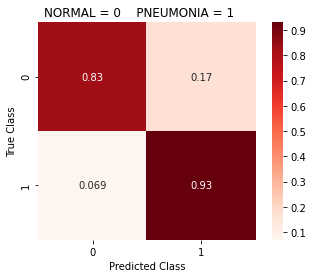

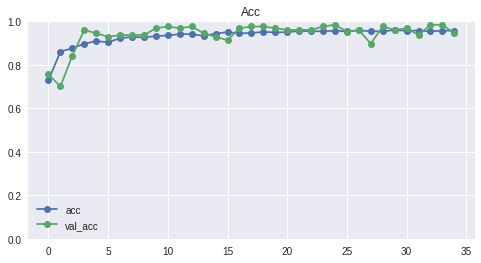

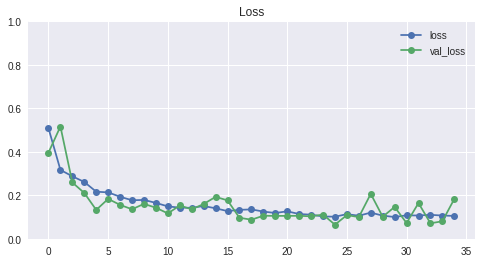

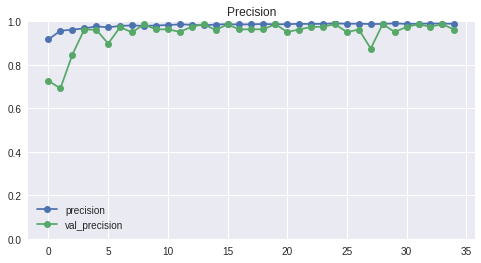

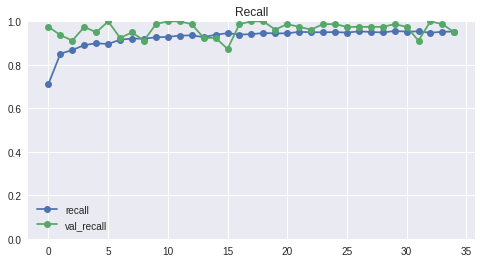

------------------------------------------------------------
16/16 [==============================] - 0s 16ms/step - loss: 0.2884 - acc: 0.8926 - precision: 0.9000 - recall: 0.9310
loss score: 0.28839099407196045
accuracy score: 0.892578125
precision score: 0.8999999761581421
recall score: 0.931034505367279

Total time to complete: 35.37minutes


In [ ]:
cnn05 = create_improved_cnn(shape=INPUT_SHAPE, 
                            opt=optimizers.Adam(learning_rate=0.001))
history05 = fit_cnn_gen(cnn05, X_train, y_train, X_val, y_val, X_test, y_test, 
                    epochs=50, batch_size=32, generator=basic_aug_train_datagen,
                    class_weights=class_weights_dict,
                    callbacks=make_callbacks(min_delta=0.001, patience=10, 
                                             save_best_only=True, f_path=BIG_PATH, 
                                             restore_best_weights=True, mode='min'))

##RECOMMENDATION:
I highly recommend taking advantage of using callbacks when running models. It allows us to specify the types of models we want to keep, and can even save them in a specified file of our choice. We can have a place holding our best models we can then compare and evaluate. 

The callbacks we have chosen prevent our models from overfitting and save the models that achieve the lowest 'val_loss' scores. There are many more callbacks, and we will be using one more later on in the project.

Trying out RMSProp

Because of the amount of time it takes to run each of these models, we will explore more options in terms of optimizers and activation functions with models that take in smaller image sizes in order to save time.

RMSProp

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 58, 58, 128)       204928    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)            

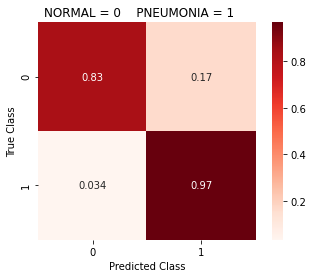

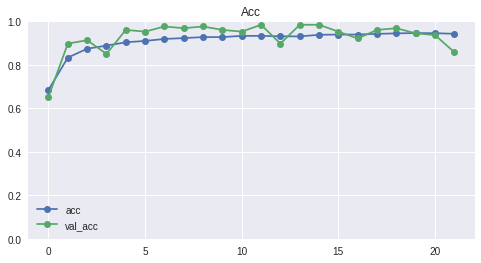

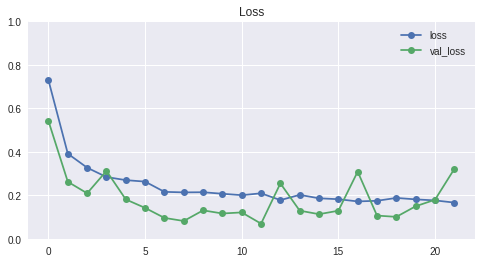

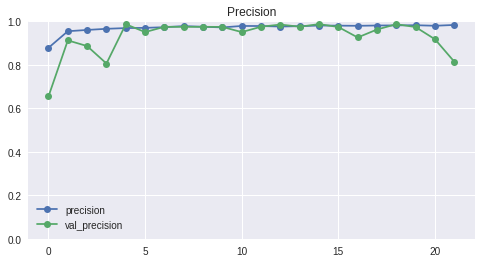

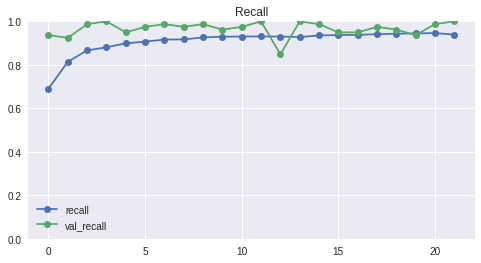

------------------------------------------------------------
16/16 [==============================] - 0s 16ms/step - loss: 0.2676 - acc: 0.9160 - precision: 0.9059 - recall: 0.9655
loss score: 0.2675880193710327
accuracy score: 0.916015625
precision score: 0.9058823585510254
recall score: 0.9655172228813171

Total time to complete: 23.93minutes


In [ ]:
# Changing the optimizer to RMSProp with a default learning rate of 0.001
cnn06 = create_improved_cnn(shape=INPUT_SHAPE, 
                            opt=tf.keras.optimizers.RMSprop(learning_rate=0.001))
history06 = fit_cnn_gen(cnn06, X_train, y_train, 
                    X_val, y_val, X_test, y_test, 
                    epochs=50, batch_size=32, generator=basic_aug_train_datagen, 
                    class_weights=class_weights_dict,
                    callbacks=make_callbacks(min_delta=0.01, patience=10, 
                                             save_best_only=True, f_path=BIG_PATH,
                                             restore_best_weights=True, mode='min'))

### Adding in more layers to our model function

In [ ]:
def create_improved_cnn02(shape='', opt=tf.keras.optimizers.Adam(), 
                          metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')]):
    if len(shape) < 1:
      print('Please define input shape!')
    else:
      model = Sequential()
      model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
      model.add(MaxPooling2D((2, 2)))
      
      model.add(layers.Conv2D(64, (3,3), activation='relu'))
      model.add(MaxPooling2D((2, 2)))

      model.add(layers.Conv2D(128, (5, 5), activation='relu'))
      model.add(MaxPooling2D((4, 4)))
      
      model.add(layers.Conv2D(256, (3, 3), activation='relu'))
      model.add(MaxPooling2D((2, 2)))
      
      model.add(Flatten())
      model.add(layers.Dense(512, activation='relu'))
      model.add(layers.Dropout(0.2))

      model.add(layers.Dense(256, activation='relu'))
      model.add(layers.Dropout(0.2))

      model.add(layers.Dense(128, activation='relu'))

      model.add(layers.Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
      return model

Epoch 1/50
163/163 [==============================] - 69s 422ms/step - loss: 0.5712 - acc: 0.6189 - precision: 0.9418 - recall: 0.6638 - val_loss: 0.7465 - val_acc: 0.6220 - val_precision: 0.8163 - val_recall: 0.5063
Epoch 2/50
163/163 [==============================] - 66s 403ms/step - loss: 0.4642 - acc: 0.7964 - precision: 0.9509 - recall: 0.7654 - val_loss: 0.7141 - val_acc: 0.6693 - val_precision: 0.7403 - val_recall: 0.7215
Epoch 3/50
163/163 [==============================] - 65s 400ms/step - loss: 0.4206 - acc: 0.8083 - precision: 0.9522 - recall: 0.7812 - val_loss: 0.7346 - val_acc: 0.5748 - val_precision: 0.6190 - val_recall: 0.8228
Epoch 4/50
163/163 [==============================] - 65s 400ms/step - loss: 0.4087 - acc: 0.8146 - precision: 0.9527 - recall: 0.7897 - val_loss: 0.5620 - val_acc: 0.7402 - val_precision: 0.7949 - val_recall: 0.7848
Epoch 5/50
163/163 [==============================] - 65s 399ms/step - loss: 0.3801 - acc: 0.8252 - precision: 0.9605 - recall: 0.79

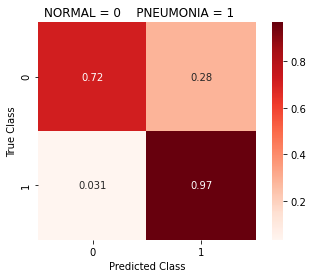

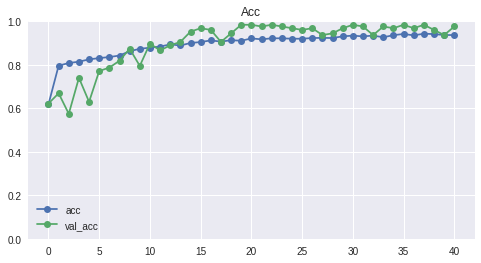

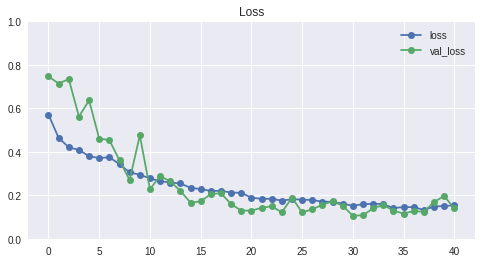

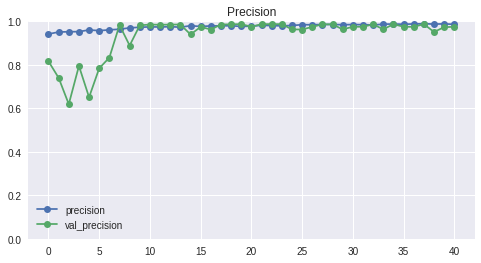

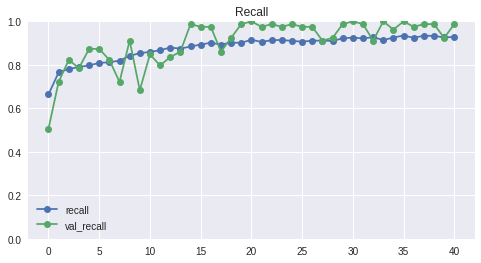

------------------------------------------------------------
16/16 [==============================] - 0s 16ms/step - loss: 0.4224 - acc: 0.8730 - precision: 0.8489 - recall: 0.9687
loss score: 0.42239391803741455
accuracy score: 0.873046875
precision score: 0.848901093006134
recall score: 0.9686520099639893

Total time to complete: 44.3minutes


In [ ]:
cnn07 = create_improved_cnn02(shape=INPUT_SHAPE, opt=optimizers.Adam(learning_rate=0.001))
history07 = fit_cnn_gen(cnn07, X_train, y_train, 
                    X_val, y_val, X_test, y_test, 
                    epochs=50, batch_size=32, generator=aug_train_datagen, 
                    class_weights=class_weights_dict,
                    callbacks=make_callbacks(min_delta=0.001, patience=10, 
                                             save_best_only=True, f_path=BIG_PATH, 
                                             restore_best_weights=True, mode='min'))

Using leakyReLU as our activation function

#### Our Best 256x256 Custom Model Architecture so far:

In [ ]:
# Replacing 'relu' as our activation function with leakyReLU
def create_cnn_leaky(shape='', opt=tf.keras.optimizers.Adam(), alpha=0.2,
                          metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')]):
    if len(shape) < 1:
      print('Please define input shape!')
    else:
      model = Sequential()
      model.add(layers.Conv2D(32, (3,3), input_shape=shape))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((2, 2)))
      
      model.add(layers.Conv2D(64, (3,3)))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(layers.Conv2D(64, (3,3)))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((2, 2)))

      model.add(layers.Conv2D(128, (5, 5)))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(layers.Conv2D(128, (5, 5)))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((4, 4)))
      
      model.add(layers.Conv2D(256, (3, 3)))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(layers.Conv2D(256, (3, 3)))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((2, 2)))
      
      model.add(Flatten())
      model.add(layers.Dense(256))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(layers.Dropout(0.2))

      model.add(layers.Dense(128))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(layers.Dropout(0.2))

      model.add(layers.Dense(64))
      model.add(layers.LeakyReLU(alpha=alpha))

      model.add(layers.Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
      return model

Epoch 1/100
163/163 [==============================] - 74s 451ms/step - loss: 0.6045 - acc: 0.5698 - precision: 0.8845 - recall: 0.4841 - val_loss: 0.4794 - val_acc: 0.8189 - val_precision: 0.9667 - val_recall: 0.7342
Epoch 2/100
163/163 [==============================] - 73s 446ms/step - loss: 0.4110 - acc: 0.8004 - precision: 0.9417 - recall: 0.7796 - val_loss: 0.4061 - val_acc: 0.8189 - val_precision: 0.9828 - val_recall: 0.7215
Epoch 3/100
163/163 [==============================] - 73s 447ms/step - loss: 0.3590 - acc: 0.8292 - precision: 0.9579 - recall: 0.8054 - val_loss: 0.2761 - val_acc: 0.8898 - val_precision: 0.9577 - val_recall: 0.8608
Epoch 4/100
163/163 [==============================] - 73s 446ms/step - loss: 0.3220 - acc: 0.8482 - precision: 0.9636 - recall: 0.8268 - val_loss: 0.2919 - val_acc: 0.8976 - val_precision: 0.9459 - val_recall: 0.8861
Epoch 5/100
163/163 [==============================] - 73s 445ms/step - loss: 0.2976 - acc: 0.8610 - precision: 0.9676 - recall:

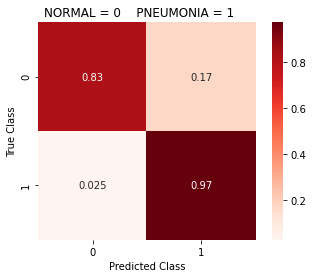

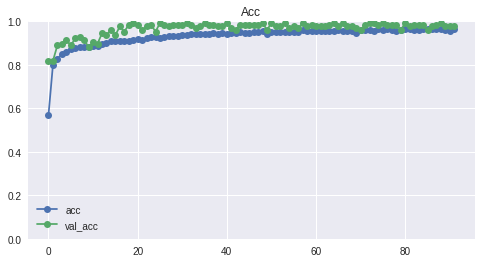

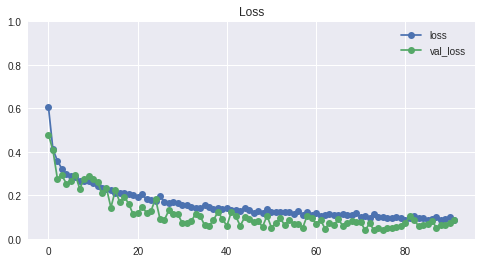

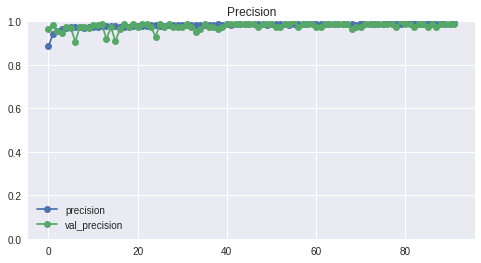

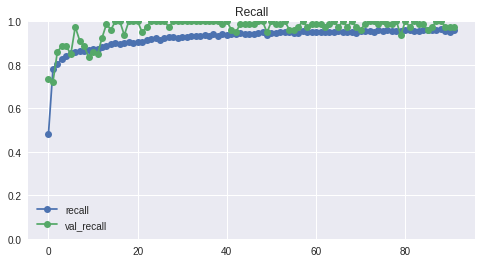

------------------------------------------------------------
16/16 [==============================] - 0s 23ms/step - loss: 0.2803 - acc: 0.9199 - precision: 0.9041 - recall: 0.9749
loss score: 0.2802964448928833
accuracy score: 0.919921875
precision score: 0.9040697813034058
recall score: 0.9749216437339783


In [ ]:
cnn08 = create_cnn_leaky(shape=INPUT_SHAPE, alpha=0.2, 
                         opt=optimizers.Adam(learning_rate=0.0001))
history08 = fit_cnn_gen(cnn08, X_train, y_train, 
                    X_val, y_val, X_test, y_test, 
                    epochs=100, batch_size=32, generator=aug_train_datagen, 
                    class_weights=class_weights_dict,
                    callbacks=make_callbacks(min_delta=0.001, patience=20, 
                                             save_best_only=True, f_path=BIG_PATH, 
                                             restore_best_weights=True, mode='min'))

The above model produced our best created model that uses 256x256 image sizes.

#### Loading in Best Models (256x256)

Best models using 256x256 image size:

In [ ]:
# Creating a new function that allows us to move models with a score higher than 
# our defined threshold into a new folder, allowing us to filter through all
# created models
def move_best_models(source, X_test, y_test, new_dir, threshold=0.9):
  """
  Definition: Moves all models within the source file if the model's accuracy
  is greater than the set threshold based off of the model.evaluate() method.

  Args:
  source: Provide the file source to filter through models.
  X_test: Provide the X_test variable to evaluate the model against.
  y_test: Provide the y_test variable to evaluate the model against.
  new_dir: Provide new directory for the filtered models to move to. Can be a 
  folder that is not yet created.
  threshold: default = 0.9. The model's accuracy must be higher than this float
  to be able to move into the new folder.

  Returns:
  Prints the evaluation metrics for each model, along with the model name if the 
  model accuracy is higher than the designated threshold. 
  """
  
  model_list = []
  os.makedirs(new_dir, exist_ok=True)
  for file in os.listdir(source):
    try:
      model = load_model(source + file)
      eval = model.evaluate(X_test, y_test)
      if eval[1] > threshold:
        print(file)
        model_list.append(file)
    except:
      continue
  for f in model_list:
          shutil.move(source+f, new_dir)

#### Filter through 256x256 models

Run this code below to filter through newly created models and place models with an accuracy > 0.90 into the new_dirs folder.

In [ ]:
# the file location where we've stored all of our 256x256 models
source = '/content/drive/MyDrive/gdrive/models/pneumonia_models/big_mods256/'

# the file location where we want to move the best models from our 'source'
new_dirs = '/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/big/'

# We define the accuracy threshold to be 0.9 -- the model must have a higher accuracy
# than 90% in order to be moved into the 'new_dirs' file
move_best_models(source, X_test, y_test, new_dirs, threshold=0.90)

16/16 [==============================] - 0s 16ms/step - loss: 0.2676 - acc: 0.9160 - precision: 0.9059 - recall: 0.9655
wgt-improv-12-0.07.hdf5
16/16 [==============================] - 0s 16ms/step - loss: 0.4224 - acc: 0.8730 - precision: 0.8489 - recall: 0.9687


Loading in our best models

In [ ]:
best_model1 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/big/wgt-improv-18-0.05.hdf5')
best_model1.evaluate(X_test, y_test)
#how to view the model's input_shape
#best_model1.layers[0].input_shape

16/16 [==============================] - 0s 16ms/step - loss: 0.2642 - acc: 0.9043 - precision: 0.8994 - recall: 0.9530


[0.2642342746257782, 0.904296875, 0.8994082808494568, 0.9529780745506287]

In [ ]:
best_model2 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/big/wgt-improv-28-0.07.hdf5')
best_model2.evaluate(X_test, y_test)
#class_report(best_model2, X_test, y_test)

16/16 [==============================] - 1s 32ms/step - loss: 0.2517 - acc: 0.9180 - precision: 0.8924 - recall: 0.9875


[0.25171783566474915, 0.91796875, 0.8923512697219849, 0.9874607920646667]

---------------------------------------------------------
                  Classification Report

              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       193
         1.0       0.90      0.97      0.94       319

    accuracy                           0.92       512
   macro avg       0.93      0.90      0.91       512
weighted avg       0.92      0.92      0.92       512

---------------------------------------------------------


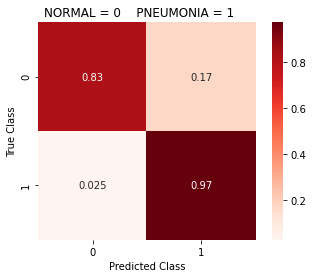

16/16 [==============================] - 1s 32ms/step - loss: 0.2803 - acc: 0.9199 - precision: 0.9041 - recall: 0.9749


[0.28029748797416687, 0.919921875, 0.9040697813034058, 0.9749216437339783]

In [ ]:
best_model3 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/big/wgt-improv-72-0.04.hdf5')
class_report(best_model3, X_test, y_test)
best_model3.evaluate(X_test, y_test)

In [ ]:
best_model4 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/big/wgt-improv-20-0.10.hdf5')
best_model4.evaluate(X_test, y_test)

16/16 [==============================] - 1s 32ms/step - loss: 0.2549 - acc: 0.9043 - precision: 0.9116 - recall: 0.9373


[0.25489237904548645, 0.904296875, 0.9115853905677795, 0.9373040795326233]

In [ ]:
best_model5 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/big/wgt-improv-14-0.14.hdf5')
best_model5.evaluate(X_test, y_test)

16/16 [==============================] - 1s 32ms/step - loss: 0.2573 - acc: 0.9102 - precision: 0.9149 - recall: 0.9436


[0.25729838013648987, 0.91015625, 0.914893627166748, 0.9435736536979675]

In [ ]:
# Viewing all the 256x256 models that have an accuracy greater than 90%
source = '/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/big/'
for file in os.listdir(source):
  try:
    model = load_model(source + file)
    eval = model.evaluate(X_test, y_test)
    if eval[1] > 0.90:
      print(file)
  except:
    continue

16/16 [==============================] - 0s 16ms/step - loss: 0.2614 - acc: 0.9004 - precision: 0.9061 - recall: 0.9373
wgt-improv-16-0.07.hdf5
16/16 [==============================] - 0s 16ms/step - loss: 0.2642 - acc: 0.9043 - precision: 0.8994 - recall: 0.9530
wgt-improv-18-0.05.hdf5
16/16 [==============================] - 0s 24ms/step - loss: 0.3447 - acc: 0.9043 - precision: 0.8835 - recall: 0.9749
wgt-improv-20-0.09.hdf5
16/16 [==============================] - 1s 32ms/step - loss: 0.2848 - acc: 0.9023 - precision: 0.8876 - recall: 0.9655
wgt-improv-15-0.17.hdf5
16/16 [==============================] - 1s 32ms/step - loss: 0.2573 - acc: 0.9102 - precision: 0.9149 - recall: 0.9436
wgt-improv-14-0.14.hdf5
16/16 [==============================] - 1s 32ms/step - loss: 0.3027 - acc: 0.9082 - precision: 0.8977 - recall: 0.9624
wgt-improv-19-0.11.hdf5
16/16 [==============================] - 1s 32ms/step - loss: 0.2549 - acc: 0.9043 - precision: 0.9116 - recall: 0.9373
wgt-improv-20-0.

## Training Models on a Smaller image size

So far, we've been training models on image sizes of 256x256. While those sizes provided more data (more pixels), they also took our models more time to train. Below, we are going to switch image sizes to 64x64 and see if we can reduce the amount of time it takes to train the models and get close to the scores of our best models that are training on larger image sizes.

In [ ]:
# Setting our new, smaller image size
SMALL_IMG = (64, 64)

# Creating new ImageDataGenerators for our small set
# Note that this is an unneeded step, we could use the other IDG's as well
train_datagen_small = ImageDataGenerator(rescale = 1./255)
test_val_datagen_small = ImageDataGenerator(rescale = 1./255, 
                                      validation_split=VAL_SPLIT)

In [ ]:
# Creating our datasets from our defined DataGenerators
train_set_small = train_datagen_small.flow_from_directory(train_folder, 
                                                   target_size=SMALL_IMG,
                                                   batch_size=TRAIN_BATCH_SIZE,
                                                   class_mode='binary')

test_set_small = test_val_datagen_small.flow_from_directory(test_folder, 
                                                     target_size=SMALL_IMG,
                                                     batch_size=TEST_BATCH_SIZE,
                                                     class_mode='binary', 
                                                     subset='training')

val_set_small = test_val_datagen_small.flow_from_directory(test_folder, 
                                                    target_size=SMALL_IMG,
                                                    batch_size=VAL_BATCH_SIZE,
                                                    class_mode='binary', 
                                                    subset='validation')

Found 5216 images belonging to 2 classes.
Found 513 images belonging to 2 classes.
Found 127 images belonging to 2 classes.


In [ ]:
# Viewing our class indices
train_set_small.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
start = time.time()
# Creating our features and labels for train, test, and validation sets
Xs_train, ys_train = next(train_set_small)
Xs_test, ys_test = next(test_set_small)
Xs_val, ys_val = next(val_set_small)
end = time.time()
print(f"Total time to run this cell: {round((end - start) / 60, 2)} minutes")

Total time to run this cell: 1.14 minutes


Pneumonia Class --> 1.0


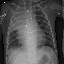

In [ ]:
random_image(Xs_train, ys_train)

In [ ]:
# Defining our new input shape
INPUT_SHAPE_small = Xs_train.shape[1:]
print(INPUT_SHAPE_small)

(64, 64, 3)


In [ ]:
# This is the same as our other DataGenerator, we are just bringing it 
# down to view the augmentations
aug_train_small_datagen = ImageDataGenerator(rotation_range=45, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

Reviewing our `fit_cnn_gen()` and `make_callbacks()` functions  

In [ ]:
# Nothing new, just reviewing what we are using
def fit_cnn_gen(model, X_train, y_train, X_val, y_val, X_test, y_test,
                generator, epochs=10, batch_size=32, plot_hist=1, 
                class_weights=None, callbacks=''):
  """
  Definition:
  Fits a passed in model saved in a variable 'history'. Then activates the 
  class_report function which returns a classification report and a confusion
  matrix. Finally, plots the history using the plot_history() function.

  Args:
  model: Requires a model.
  X_train: Requires a train set of features.
  y_train: Requires a train set of labels.
  X_val: Requires a validation set of features.
  y_val: Requires a validation set of labels.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  generator: Selected generator to augment training data. This variable will use 
  the .flow() function to gather data from X_train and y_train to augment the 
  training data. 
  epochs: default = 10. Defines the number of passes the ML algorithm will complete.
  batch_size: default = 32. Defines the number of training examples utilized in
  one iteration before updating internal parameters.
  plot_hist: default = 1. Defines whether or not the plot_history() function will
  be executed. 
  class_weights: default = None. Pass in a dictionary containing the class weights, 
  where the keys are the classes and the values are the weights.
  callbacks: default = ''. will pass in a list of callbacks into the model.fit() 
  if this variable contains the list of callbacks (can pass in the make_callbacks()).
  If left at default, no callbacks will be used.

  Returns:
  history, prints classification report, confusion matrix, and plots history metrics.
  """
  start = time.time()
  if len(callbacks) > 0:
    history = model.fit(generator.flow(X_train, y_train, batch_size=batch_size), 
                        validation_data=(X_val, y_val), 
                        epochs=epochs, class_weight=class_weights,
                        callbacks=callbacks)
  else:
    history = model.fit(generator.flow(X_train, y_train, batch_size=batch_size), 
                        validation_data=(X_val, y_val), 
                        epochs=epochs, class_weight=class_weights)
    
  class_report(model, X_test, y_test)
    
  if plot_hist:
      plot_history(history) 
  
  dashes = '---'*20
  print(dashes)
  eval_scores = model.evaluate(X_test, y_test)
  metric_list=['loss', 'accuracy', 'precision', 'recall']
  for i, score in enumerate(eval_scores):
    print(f"{metric_list[i]} score: {score}")

  end = time.time()
  print(f"\nTotal time to complete: {round((end-start)/60, 2)} minutes")
  return history

In [ ]:
def make_callbacks(monitor='val_loss', min_delta=0, patience=0, mode='auto', 
                   f_path='/content/drive/My Drive/gdrive/models/pneumonia_models/', 
                   restore_best_weights=False, save_best_only=False, 
                   save_freq='epoch'):
  """
  Definition:
  Creates two variables, and then returns these variables in a list.

  1. variable 'earlystop' stops model training when the 'monitor' metric has not 
  improved past the 'min_delta' threshold after a certain amount of epochs, 
  defined by 'patience'. 

  2. variable 'checkpoint' saves model at some interval, so the model can be 
  loaded later on to continue the training from the saved state.

  Args:
  monitor: default = 'val_loss'. Quantity to be monitored during training.
  min_delta: default = 0. minimum change in the monitored quantity to be
  considered an improvement.
  patience: default = 0. The number of epochs with no improvement after which
  training will be stopped.
  mode: default = 'auto'. Defines the direction of monitor quantity. ex. If 'min', 
  training will stop after monitored quantity is no longer decreasing past the 
  defined min_delta. 
  f_path: default = '/content/drive/My Drive/gdrive/models/pneumonia_models/'. 
  The filepath that will be created / set as the destination for saved models 
  from 'checkpoint' variable.
  restore_best_weights: default = False. Defines whether or not to restore the 
  best model weights from the epoch with the best value of the monitored quantity.
  save_best_only: default = False. If save_best_only=True, the latest best model 
  according to the quantity monitored will not be overwritten.
  save_freq: default = 'epoch'. The defined interval at which the model is saved.

  Returns:
  A list named 'callbacks' containing the 'earlystop' and 'checkpoint' variable.
  """
  
  # Defining our early stopping func
  earlystop = EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, 
                           mode=mode, restore_best_weights=restore_best_weights)
    
  #checking to make sure our path is set up. If not, the line below creates it.
  os.makedirs(f_path, exist_ok=True)
    
  # saves the current model at the specified checkpoint
  checkpoint_f_path = f_path+"wgt-improv-{epoch:02d}-{"+monitor+":.2f}.hdf5"
  checkpoint = ModelCheckpoint(filepath=checkpoint_f_path, monitor=monitor, 
                               save_best_only=save_best_only, mode=mode, 
                               save_freq=save_freq)
  callbacks = [earlystop, checkpoint]
  return callbacks

### Run small path here

In [ ]:
# New path to put our models with smaller images
SMALL_PATH = '/content/drive/My Drive/gdrive/models/pneumonia_models/small_mods64/'

In [ ]:
# Creating a CNN for our 64x64 images; notice we added the padding parameter to
# equal 'same' instead of the default 'valid'
def create_small_cnn(shape='', opt=tf.keras.optimizers.Adam(), 
                          metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')]):
    if len(shape) < 1:
      print('Please define input shape!')
    else:
      model = Sequential()
      model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', 
                              input_shape=shape))
      model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
      model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

      model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
      model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
      model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

      #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
      # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
      # model.add(MaxPooling2D((3, 3)))

      model.add(Flatten())

      model.add(layers.Dense(64, activation='relu'))
      model.add(layers.Dropout(0.2))
      model.add(layers.Dense(64, activation='relu'))

      model.add(layers.Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
      print(model.summary())
      return model


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)            

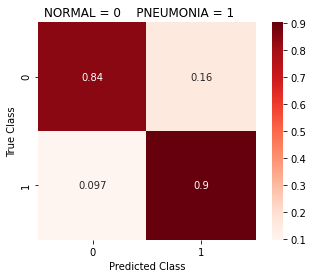

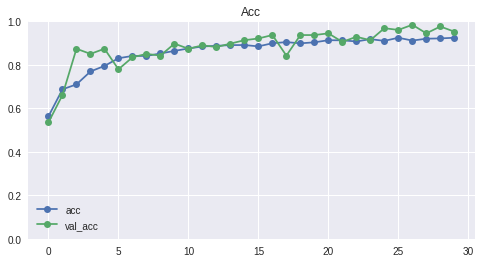

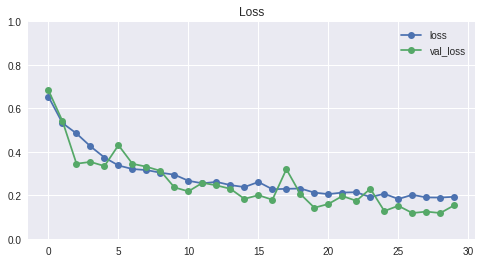

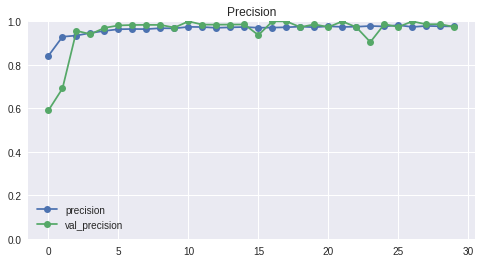

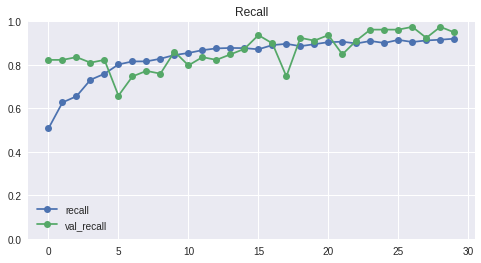

------------------------------------------------------------
16/16 [==============================] - 0s 3ms/step - loss: 0.2754 - acc: 0.8809 - precision: 0.9057 - recall: 0.9028
loss score: 0.2754409909248352
accuracy score: 0.880859375
precision score: 0.9056603908538818
recall score: 0.9028213024139404

Total time to complete: 2.72 minutes


In [ ]:
cnn_small01 = create_small_cnn(shape=INPUT_SHAPE_small, 
                               opt=tf.keras.optimizers.Adam(learning_rate=0.001))
history_sm01 = fit_cnn_gen(cnn_small01, Xs_train, ys_train, 
                        Xs_val, ys_val, Xs_test, ys_test, 
                        batch_size=32, epochs=30, 
                        generator=aug_train_small_datagen,
                        class_weights=class_weights_dict, 
                        callbacks=make_callbacks(patience=5, min_delta=0.001, 
                                                 mode='min', 
                                                 f_path=SMALL_PATH,
                                                 save_best_only=True))

The model above performed well - but we also notice that because we using smaller image sizes, our model trained much faster than other models trained using 256x256 images. Let's try and change our activation function to leaky relu, since that activation function did outperform our other models that were trained on 256x256 images that used reLU as the activation function.

The Difference between ReLU and LeakyReLU

The gist I've  gotten so far:

The 'dying ReLU' problem = when the input values are less than 0, ReLU considers those values to be 0. If the derivative of the slope of the ReLU is of 0, absolutely no learning is performed on the layers below the dead ReLU == dead neurons. LeakyReLU solves this problem by giving input values less than 0 a slightly negative number instead of 0 == solves the problem of having dead neurons. 

In [ ]:
# Creating a CNN to use leakyReLU as the activation function using our small images
def create_cnn_leaky_small(shape='', opt=tf.keras.optimizers.Adam(), alpha=0.2,
                          metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')]):
    if len(shape) < 1:
      print('Please define input shape!')
    else:
      model = Sequential()
      model.add(layers.Conv2D(32, (3,3), input_shape=shape))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((2, 2)))
      
      model.add(layers.Conv2D(64, (3,3)))
      model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(layers.Conv2D(64, (3,3)))
      # model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((2, 2)))

      model.add(layers.Conv2D(128, (3, 3)))
      model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(layers.Conv2D(128, (3, 3)))
      # model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((2, 2)))
      
      # model.add(layers.Conv2D(256, (3, 3)))
      # model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(layers.Conv2D(256, (3, 3)))
      # model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(MaxPooling2D((2, 2)))
      
      model.add(Flatten())
      # model.add(layers.Dense(256))
      # model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(layers.Dropout(0.2))

      model.add(layers.Dense(128))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(layers.Dropout(0.2))

      model.add(layers.Dense(64))
      model.add(layers.LeakyReLU(alpha=alpha))

      model.add(layers.Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
      print(model.summary())
      return model

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 128)      

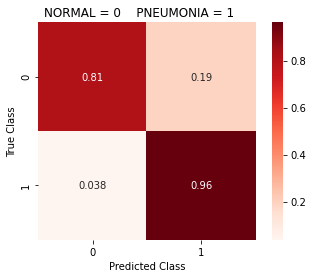

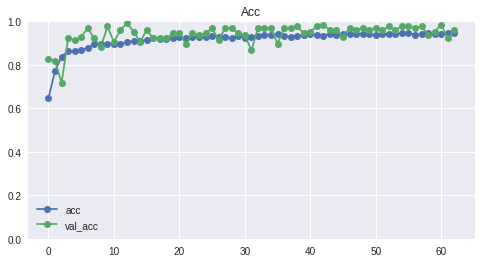

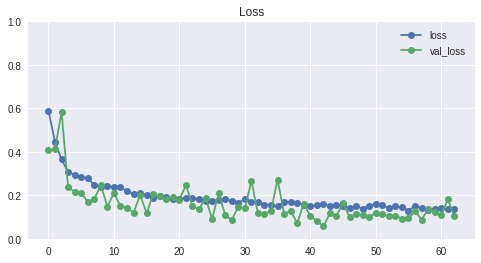

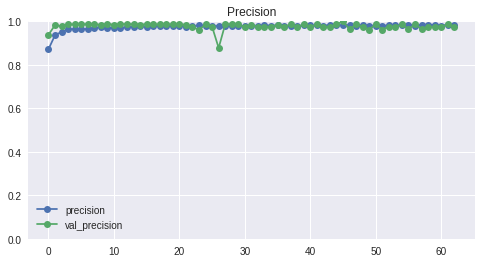

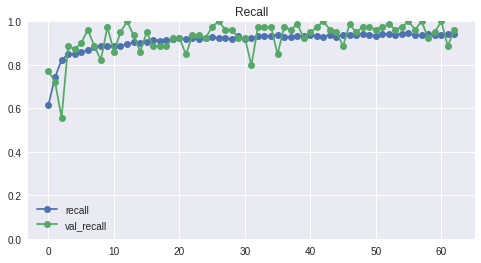

------------------------------------------------------------
16/16 [==============================] - 0s 4ms/step - loss: 0.3059 - acc: 0.9043 - precision: 0.8924 - recall: 0.9624
loss score: 0.30594193935394287
accuracy score: 0.904296875
precision score: 0.8924418687820435
recall score: 0.962382435798645

Total time to complete: 5.59 minutes


In [ ]:
cnn_sl = create_cnn_leaky_small(shape=INPUT_SHAPE_small, alpha=0.2, 
                         opt=optimizers.Adam(learning_rate=0.001))
history_sl = fit_cnn_gen(cnn_sl, Xs_train, ys_train, 
                    Xs_val, ys_val, Xs_test, ys_test, 
                    epochs=100, batch_size=32, generator=aug_train_small_datagen, 
                    class_weights=class_weights_dict,
                    callbacks=make_callbacks(min_delta=0.001, patience=20, 
                                             save_best_only=True, 
                                             f_path=SMALL_PATH, 
                                             restore_best_weights=True, mode='min'))

In [ ]:
# Creating CNN that uses leakyReLU and padding='same'
def create_cnn_leaky_small_pads(shape='', opt=tf.keras.optimizers.Adam(), alpha=0.2,
                          metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')]):
    if len(shape) < 1:
      print('Please define input shape!')
    else:
      model = Sequential()
      model.add(layers.Conv2D(32, (3,3), input_shape=shape, padding='same'))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((2, 2), padding='same'))
      
      model.add(layers.Conv2D(64, (3,3), padding='same'))
      model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(layers.Conv2D(64, (3,3)))
      # model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((2, 2), padding='same'))

      model.add(layers.Conv2D(128, (3, 3), padding='same'))
      model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(layers.Conv2D(128, (3, 3)))
      # model.add(layers.LeakyReLU(alpha=alpha))
      model.add(MaxPooling2D((2, 2), padding='same'))
      
      # model.add(layers.Conv2D(256, (3, 3)))
      # model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(layers.Conv2D(256, (3, 3)))
      # model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(MaxPooling2D((2, 2)))
      
      model.add(Flatten())
      # model.add(layers.Dense(256))
      # model.add(layers.LeakyReLU(alpha=alpha))
      # model.add(layers.Dropout(0.2))

      model.add(layers.Dense(128))
      model.add(layers.LeakyReLU(alpha=alpha))
      model.add(layers.Dropout(0.2))

      model.add(layers.Dense(64))
      model.add(layers.LeakyReLU(alpha=alpha))

      model.add(layers.Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
      print(model.summary())
      return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 128)      

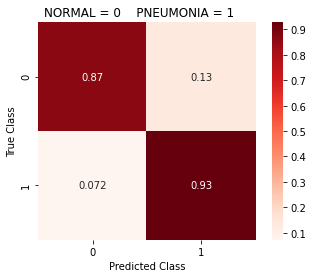

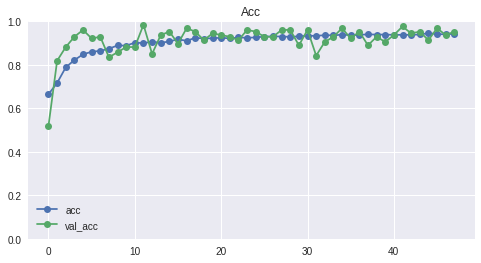

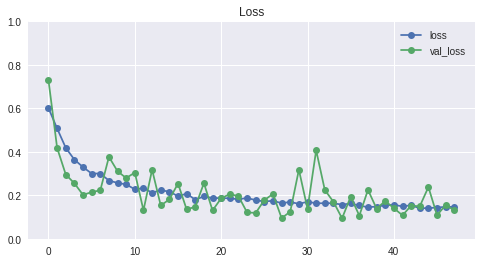

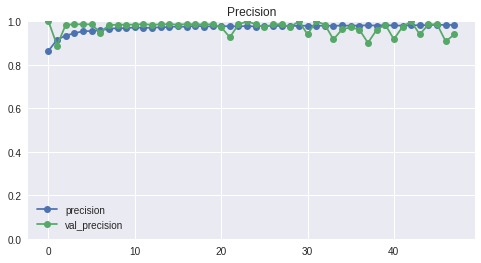

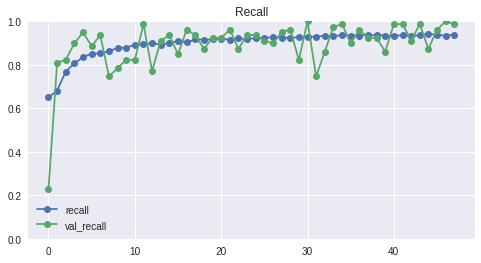

------------------------------------------------------------
16/16 [==============================] - 0s 4ms/step - loss: 0.2711 - acc: 0.9043 - precision: 0.9193 - recall: 0.9279
loss score: 0.2710723876953125
accuracy score: 0.904296875
precision score: 0.9192546606063843
recall score: 0.9278996586799622

Total time to complete: 4.28 minutes


In [ ]:
cnn_slp = create_cnn_leaky_small_pads(shape=INPUT_SHAPE_small, alpha=0.2, 
                         opt=optimizers.Adam(learning_rate=0.001))
history_slp = fit_cnn_gen(cnn_slp, Xs_train, ys_train, 
                    Xs_val, ys_val, Xs_test, ys_test, 
                    epochs=100, batch_size=32, generator=aug_train_small_datagen, 
                    class_weights=class_weights_dict,
                    callbacks=make_callbacks(min_delta=0.001, patience=20, 
                                             save_best_only=True, 
                                             f_path=SMALL_PATH, 
                                             restore_best_weights=True, mode='min'))

### Loading in Best Models (64x64)

In [ ]:
# Nothing new in this function, bringing it down for us to view
def move_best_models(source, X_test, y_test, new_dir, threshold=0.9):
  """
  Definition: Moves all models within the source file if the model's accuracy
  is greater than the set threshold based off of the model.evaluate() method.

  Args:
  source: Provide the file source to filter through models.
  X_test: Provide the X_test variable to evaluate the model against.
  y_test: Provide the y_test variable to evaluate the model against.
  new_dir: Provide new directory for the filtered models to move to. Can be a 
  folder that is not yet created.
  threshold: default = 0.9. The model's accuracy must be higher than this float
  to be able to move into the new folder.

  Returns:
  Prints the evaluation metrics for each model, along with the model name if the 
  model accuracy is higher than the designated threshold. 
  """

  model_list = []
  os.makedirs(new_dir, exist_ok=True)
  for file in os.listdir(source):
    try:
      model = load_model(source + file)
      eval = model.evaluate(X_test, y_test)
      if eval[1] > threshold:
        print(file)
        model_list.append(file)
    except:
      continue
  for f in model_list:
          shutil.move(source+f, new_dir)

#### Filter through 64x64 models

Run this code to filter through newly created 64x64 models

In [ ]:
# Same process as before - taking models from our 'source' if they score higher
# than our defined threshold, and moving them into our 'new_dirs' address
source = '/content/drive/MyDrive/gdrive/models/pneumonia_models/small_mods64/'
new_dirs = '/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/small/'
move_best_models(source, Xs_test, ys_test, new_dirs, threshold=0.90)

16/16 [==============================] - 0s 3ms/step - loss: 0.3059 - acc: 0.9043 - precision: 0.8924 - recall: 0.9624
wgt-improv-43-0.06.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 0.2654 - acc: 0.9082 - precision: 0.8908 - recall: 0.9718
wgt-improv-27-0.08.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 0.2513 - acc: 0.9082 - precision: 0.9024 - recall: 0.9561
wgt-improv-47-0.07.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 0.2877 - acc: 0.9121 - precision: 0.8914 - recall: 0.9781
wgt-improv-49-0.06.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 0.2737 - acc: 0.9023 - precision: 0.8944 - recall: 0.9561
wgt-improv-21-0.08.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 0.2697 - acc: 0.9004 - precision: 0.8941 - recall: 0.9530
wgt-improv-28-0.10.hdf5
16/16 [==============================] - 0s 3ms/step - loss: 0.2593 - acc: 0.9023 - precision: 0.9113 - recall: 0.9342
wgt-improv-32-0.09.hdf5

Loading in some of our best 64x64 models

---------------------------------------------------------
                  Classification Report

              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90       194
         1.0       0.92      0.97      0.95       318

    accuracy                           0.93       512
   macro avg       0.94      0.92      0.92       512
weighted avg       0.93      0.93      0.93       512

---------------------------------------------------------


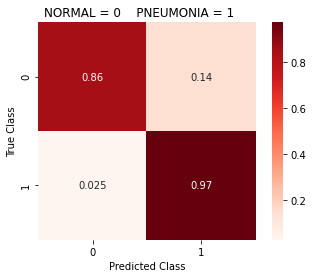

16/16 [==============================] - 0s 4ms/step - loss: 0.2220 - acc: 0.9297 - precision: 0.9172 - recall: 0.9748


[0.2220173478126526, 0.9296875, 0.9171597361564636, 0.9748427867889404]

In [ ]:
# Our 64x64 model with highest accuracy
best_sm_model1 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/small/wgt-improv-71-0.04.hdf5')
class_report(best_sm_model1, Xs_test, ys_test)
best_sm_model1.evaluate(Xs_test, ys_test)

In [ ]:
#best_sm_model1.summary()

In [ ]:
best_sm_model2 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/small/wgt-improv-61-0.05.hdf5')
best_sm_model2.evaluate(Xs_test, ys_test)

16/16 [==============================] - 0s 4ms/step - loss: 0.2285 - acc: 0.9199 - precision: 0.9315 - recall: 0.9403


[0.22854068875312805, 0.919921875, 0.9314641952514648, 0.9402515888214111]

In [ ]:
best_sm_model3 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/small/wgt-improv-24-0.10.hdf5')
best_sm_model3.evaluate(Xs_test, ys_test)

16/16 [==============================] - 0s 4ms/step - loss: 0.2792 - acc: 0.9082 - precision: 0.9387 - recall: 0.9122


[0.279170960187912, 0.908203125, 0.9387096762657166, 0.9122257232666016]

---------------------------------------------------------
                  Classification Report

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       194
         1.0       0.93      0.95      0.94       318

    accuracy                           0.93       512
   macro avg       0.92      0.92      0.92       512
weighted avg       0.93      0.93      0.93       512

---------------------------------------------------------


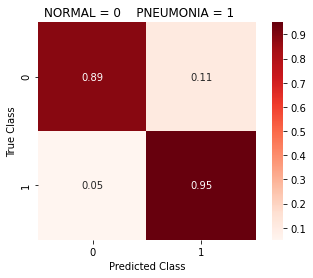

16/16 [==============================] - 0s 4ms/step - loss: 0.2344 - acc: 0.9258 - precision: 0.9321 - recall: 0.9497


[0.234402596950531, 0.92578125, 0.9320987462997437, 0.9496855139732361]

In [ ]:
# Our 64x64 model with best sensitivity and specificity (recall for both classes)
best_sm_model4 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/small/wgt-improv-45-0.05.hdf5')
class_report(best_sm_model4, Xs_test, ys_test)
best_sm_model4.evaluate(Xs_test, ys_test)

In [ ]:
best_sm_model5 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/small/wgt-improv-57-0.05.hdf5')
best_sm_model5.evaluate(Xs_test, ys_test)

16/16 [==============================] - 0s 4ms/step - loss: 0.2464 - acc: 0.9141 - precision: 0.9056 - recall: 0.9624


[0.2464161515235901, 0.9140625, 0.9056047201156616, 0.962382435798645]

Run this code below to view best 64x64 models found according to accuracy score

In [ ]:
# Viewing our best 64x64 models we've saved so far
source = '/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/small/'
for file in os.listdir(source):
  try:
    model = load_model(source + file)
    eval = model.evaluate(Xs_test, ys_test)
    if eval[1] > 0.90:
      print(file)
  except:
    continue

16/16 [==============================] - 0s 4ms/step - loss: 0.2794 - acc: 0.9082 - precision: 0.9385 - recall: 0.9119
wgt-improv-24-0.10.hdf5
16/16 [==============================] - 0s 4ms/step - loss: 0.2501 - acc: 0.9043 - precision: 0.9063 - recall: 0.9434
wgt-improv-20-0.12.hdf5
16/16 [==============================] - 0s 4ms/step - loss: 0.3015 - acc: 0.9043 - precision: 0.8921 - recall: 0.9623
wgt-improv-10-0.12.hdf5
16/16 [==============================] - 0s 4ms/step - loss: 0.2802 - acc: 0.9141 - precision: 0.9029 - recall: 0.9654
wgt-improv-29-0.06.hdf5
16/16 [==============================] - 0s 4ms/step - loss: 0.2956 - acc: 0.9023 - precision: 0.9085 - recall: 0.9371
wgt-improv-11-0.16.hdf5
16/16 [==============================] - 0s 4ms/step - loss: 0.2720 - acc: 0.9141 - precision: 0.8914 - recall: 0.9811
wgt-improv-33-0.06.hdf5
16/16 [==============================] - 0s 4ms/step - loss: 0.2494 - acc: 0.9121 - precision: 0.8980 - recall: 0.9686
wgt-improv-45-0.06.hdf5

##RECOMMENDATION:

If you are short on time, I recommend reducing image size in order to speed up training. Our 64x64 models trained significantly faster (about 10 times faster) than the models that dealt with 256x256 images.

### Using ReduceLROnPlateau

Our third callback we will be using in this project is `ReduceLROnPlateau`. What this callback does is it lowers the learning rate after a certain threshold has not been met for a certain amount of iterations. Similar to EarlyStopping, ReduceLROnPlateau has a `patience` variable. The patience variable is the number of epochs that must run (and there is no improvement in our monitored value) before the learning rate is reduced. Once the model does not improve after a certain number of epochs, our learning rate will be multiplied by the `factor` variable. The new `learning rate = old learning rate * factor`. There are other parameters we use that you can see the definition of below.

Basically, we are aiming to implement learning rate decay on our model. "The learning rate is used to control how much we adjust the weights of our model with respect to the loss gradient." With a higher learning rate, we take a bigger step downt the slope of the gradient -- and smaller learning rate = smaller step down the slope. If the learning rate is too large the model may never converge on a local minima (arrive at our best accuracy) and if the learning rate is too small, the model may take an extremely long time to arrive at the local minima. By using ReduceLROnPlateau we can reduce our learning rate if we don't see a change in a specified monitored value, allowing us to converge at a decent pace.

In [ ]:
# adding in our third callback ReduceLROnPlateau - creating new function()
def three_callbacks(monitor='val_loss', min_delta=0, patience=0, mode='auto', 
                   f_path='/content/drive/My Drive/gdrive/models/pneumonia_models/', 
                   restore_best_weights=False, save_best_only=False, 
                   save_freq='epoch', lr_patience=5, factor=0.1, cd=0):
  """
  Definition:
  Creates three variables, and then returns these variables in a list.

  1. variable 'earlystop' stops model training when the 'monitor' metric has not 
  improved past the 'min_delta' threshold after a certain amount of epochs, 
  defined by 'patience'. 

  2. variable 'checkpoint' saves model at some interval, so the model can be 
  loaded later on to continue the training from the saved state.
	
	3. variable 'reducelr' reduces learning rate after a certain number of intervals.

  Args:
  monitor: default = 'val_loss'. Quantity to be monitored during training.
  min_delta: default = 0. minimum change in the monitored quantity to be
  considered an improvement.
  patience: default = 0. The number of epochs with no improvement after which
  training will be stopped.
  mode: default = 'auto'. Defines the direction of monitor quantity. ex. If 'min', 
  training will stop after monitored quantity is no longer decreasing past the 
  defined min_delta. 
  f_path: default = '/content/drive/My Drive/gdrive/models/pneumonia_models/'. 
  The filepath that will be created / set as the destination for saved models 
  from 'checkpoint' variable.
  restore_best_weights: default = False. Defines whether or not to restore the 
  best model weights from the epoch with the best value of the monitored quantity.
  save_best_only: default = False. If save_best_only=True, the latest best model 
  according to the quantity monitored will not be overwritten.
  save_freq: default = 'epoch'. The defined interval at which the model is saved.
  lr_patience: default = 5. Dictates how long the ReduceLROnPlateau callback must 
	wait until it can initiate learning rate decay if there is no improvement in the monitored
	metric.
	factor: default = 0.1. Float that is multipled by the current learning rate. This action is 
	learning rate decay, and the product is the new learning rate until training stops.
	cooldown: default = 0. Defines how long the ReduceLROnPlateau must wait until it
	may begin lr_patience after initiating learning rate decay. 

  Returns:
  A list named 'callbacks' containing the 'earlystop', 'checkpoint', and
  'reducelr' variable.
  """
  
  # Defining our early stopping func
  earlystop = EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience, 
                            mode=mode, restore_best_weights=restore_best_weights)
    
  #checking to make sure our path is set up. If not, the line below creates it.
  os.makedirs(f_path, exist_ok=True)
    
  # saves the current model at the specified checkpoint
  checkpoint_f_path = f_path+"wgt-improv-{epoch:02d}-{"+monitor+":.2f}.hdf5"
  checkpoint = ModelCheckpoint(filepath=checkpoint_f_path, monitor=monitor, 
                               save_best_only=save_best_only, mode=mode, 
                               save_freq=save_freq)
  # reduces learning rate after a certain number of epochs if the monitored
  # parameter has not decreased more than min_delta
  reducelr = ReduceLROnPlateau(monitor=monitor, mode=mode, min_delta=min_delta, 
                               patience=lr_patience, min_lr=1e-5,factor=factor, 
                               cooldown=cd, verbose=1)
  # Store our callbacks into a list called 'callbacks'
  callbacks = [earlystop, checkpoint, reducelr]
  return callbacks

Using our ReLU CNN with LR Decay

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)            

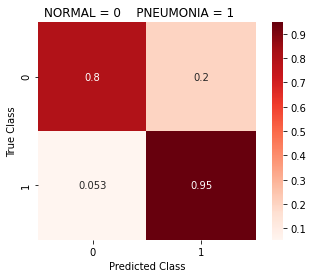

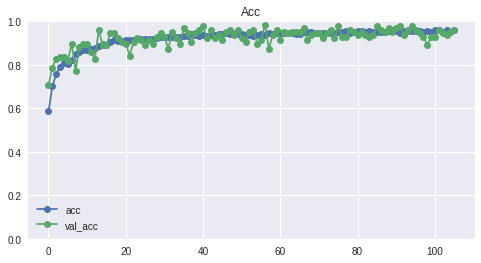

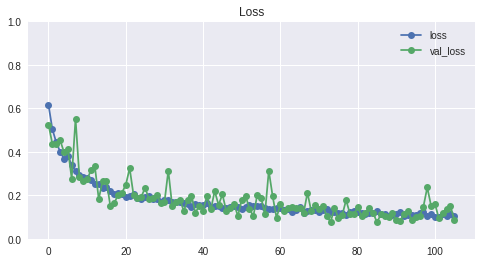

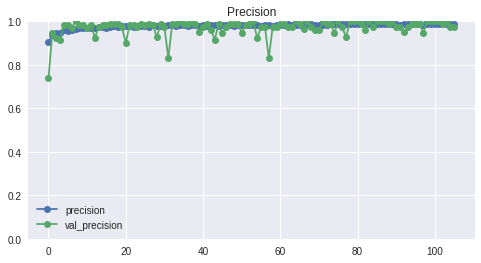

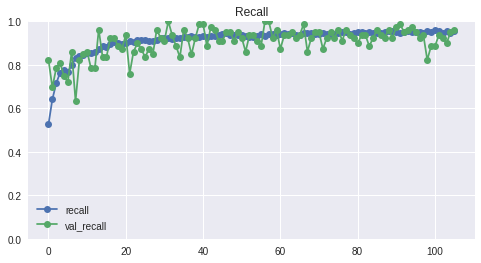

------------------------------------------------------------
16/16 [==============================] - 0s 4ms/step - loss: 0.2857 - acc: 0.8906 - precision: 0.8856 - recall: 0.9467
loss score: 0.28572025895118713
accuracy score: 0.890625
precision score: 0.8856304883956909
recall score: 0.9467084407806396

Total time to complete: 9.57 minutes


In [ ]:
cnn_small02 = create_small_cnn(shape=INPUT_SHAPE_small, 
                               opt=tf.keras.optimizers.Adam(learning_rate=0.001))
history_sm02 = fit_cnn_gen(cnn_small02, Xs_train, ys_train, 
                        Xs_val, ys_val, Xs_test, ys_test, 
                        batch_size=32, epochs=120, 
                        generator=aug_train_small_datagen,
                        class_weights=class_weights_dict, 
                        callbacks=three_callbacks(min_delta=0.001, patience=20, 
                                             save_best_only=True, factor=0.9,
                                             f_path=SMALL_PATH, lr_patience=12,
                                             restore_best_weights=True, 
                                             mode='min'))

Using our leaky CNN with Learning Rate Decay

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 12, 12, 128)     

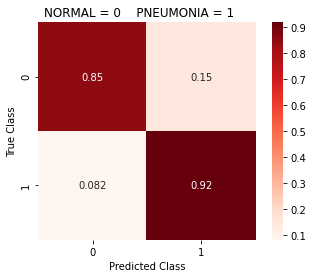

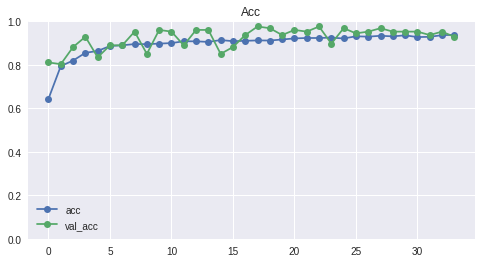

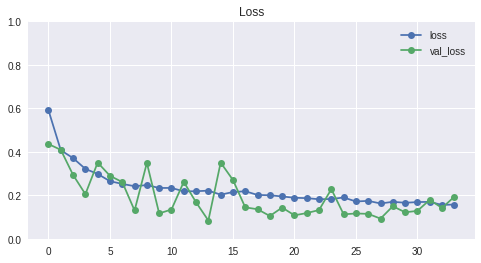

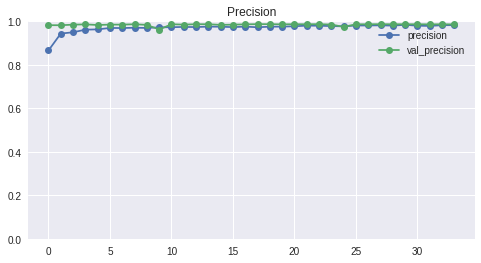

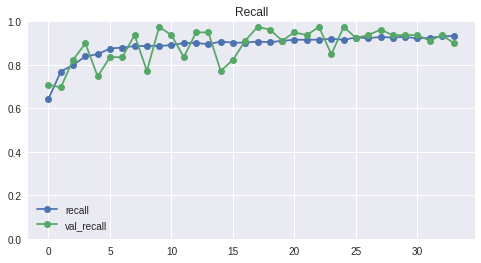

------------------------------------------------------------
16/16 [==============================] - 0s 4ms/step - loss: 0.2575 - acc: 0.8926 - precision: 0.9099 - recall: 0.9185
loss score: 0.25750547647476196
accuracy score: 0.892578125
precision score: 0.909937858581543
recall score: 0.9184952974319458

Total time to complete: 3.05 minutes


In [ ]:
cnn_sl = create_cnn_leaky_small(shape=INPUT_SHAPE_small, alpha=0.3, 
                         opt=optimizers.Adam(learning_rate=0.001))
# Using our three_callbacks in the 'callbacks' variable.
history_sl = fit_cnn_gen(cnn_sl, Xs_train, ys_train, 
                    Xs_val, ys_val, Xs_test, ys_test, 
                    epochs=120, batch_size=32, generator=aug_train_small_datagen, 
                    class_weights=class_weights_dict,
                    callbacks=three_callbacks(min_delta=0.001, patience=20, 
                                             save_best_only=True, factor=0.9,
                                             f_path=SMALL_PATH, lr_patience=8,
                                             restore_best_weights=True, 
                                             mode='min'))

Using learning rate decay through ReduceLROnPlateau has proven to train the best model - our best model that has come out of here has an accuracy of 93%.

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 128)     

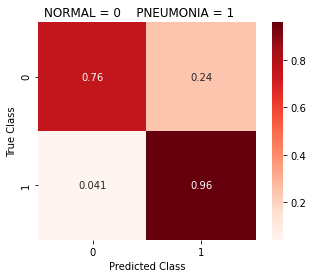

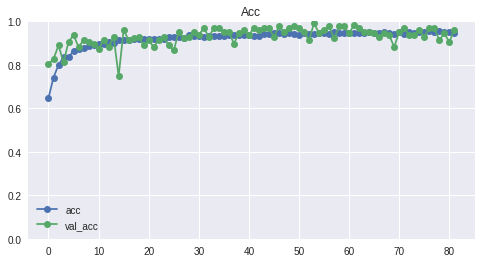

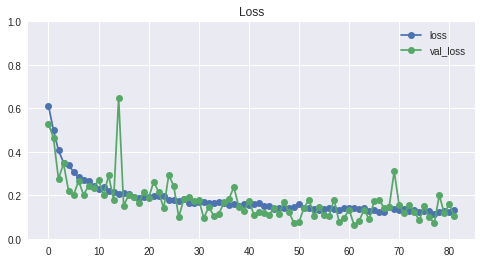

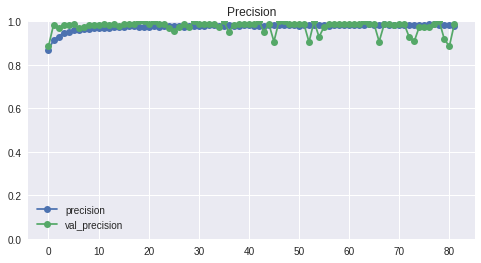

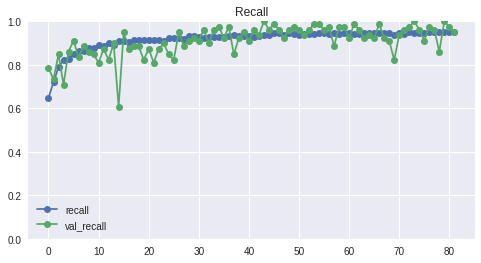

------------------------------------------------------------
16/16 [==============================] - 0s 4ms/step - loss: 0.3744 - acc: 0.8848 - precision: 0.8693 - recall: 0.9592
loss score: 0.3744133710861206
accuracy score: 0.884765625
precision score: 0.8693181872367859
recall score: 0.9592476487159729

Total time to complete: 7.31 minutes


In [ ]:
cnn_slp = create_cnn_leaky_small_pads(shape=INPUT_SHAPE_small, alpha=0.3, 
                         opt=optimizers.Adam(learning_rate=0.001))
history_slp = fit_cnn_gen(cnn_slp, Xs_train, ys_train, 
                    Xs_val, ys_val, Xs_test, ys_test, 
                    epochs=100, batch_size=32, generator=aug_train_small_datagen, 
                    class_weights=class_weights_dict,
                    callbacks=three_callbacks(min_delta=0.001, patience=20, 
                                             save_best_only=True, factor=0.9,
                                             f_path=SMALL_PATH, lr_patience=12,
                                             restore_best_weights=True, 
                                             mode='min'))

## Applying Transfer Learning Models


Transfer Learning models are models trained off of hundreds of thousands of images, and depending on what the current problem we are dealing with will more or less determine the transfer model we will want to use. **When used appropriately**, transfer models can converge quicker and have a higher starting accuracy than some custom built models. 

According to Hashmi, Mohammad Farukh et al., "Different neural networks require images of different sizes according to their defined architecture. ResNet18, DenseNet121, and MobileNetV2 expect images of size 224 × 224, while InceptionV3 and Xception require images of size 229 × 229." [2]

The first transfer model we will be trying out will be the VGG-19 model. This model has been trained on images with a size of 224x224, so we will make a new generator, test, and validation set to feed into our transfer model with that image shape.

In [ ]:
# Doing what we've done before to create our features and labels for train, test, 
# and validation sets and turning it into a function we can use
def create_train_test_val(image_size, train_batch_size=TRAIN_BATCH_SIZE, 
                          test_batch_size=TEST_BATCH_SIZE, 
                          val_batch_size=VAL_BATCH_SIZE, val_split=0.2):
  """
  Definition:
  Creates an IDG for train and test data with a validation split, and then generates
  and returns train, test, and val sets according to specified image size.

  Args:
  image_size: Required. The image shape for all sets.
  train_batch_size: Required. The size of the training data.
  test_batch_size: Required. The size of the test data.
  val_batch_size: Required. The size of the validation data.
  val_split: default = 0.2. The percentage of data to be taken from test data to 
  create the validation data.

  Returns:
  X_train, y_train, X_test, y_test, X_val, y_val
  """
  train_datagen = ImageDataGenerator(rescale = 1./255)
  test_val_datagen = ImageDataGenerator(rescale = 1./255, 
                                        validation_split=val_split)

  train_set = train_datagen.flow_from_directory(train_folder, 
                                                   target_size=image_size,
                                                   batch_size=train_batch_size,
                                                   class_mode='binary')

  test_set = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=image_size,
                                                     batch_size=test_batch_size,
                                                     class_mode='binary', 
                                                     subset='training')

  val_set = test_val_datagen.flow_from_directory(test_folder, 
                                                    target_size=image_size,
                                                    batch_size=val_batch_size,
                                                    class_mode='binary', 
                                                    subset='validation')
  start = time.time()
  X_train, y_train = next(train_set)
  X_test, y_test = next(test_set)
  X_val, y_val = next(val_set)
  end = time.time()
  print(f"Total time to run this cell: {round((end - start) / 60, 2)} minutes")
  return X_train, y_train, X_test, y_test, X_val, y_val



In [ ]:
# Creating new features and labels for each set according to our defined image_size
Xt_train, yt_train, Xt_test, yt_test, Xt_val, yt_val = create_train_test_val(image_size=(224, 224))
INPUT_SHAPE_tf = Xt_train.shape[1:]

Found 5216 images belonging to 2 classes.
Found 513 images belonging to 2 classes.
Found 127 images belonging to 2 classes.
Total time to run this cell: 1.0 minutes


#### VGG-19

Below we will define a function that can use any transfer learning model as a base, and we provide the top layers

In [ ]:
  vgg_base = VGG19(input_shape=INPUT_SHAPE_tf, weights='imagenet', 
                   include_top=False)

80142336/80134624 [==============================] - 3s 0us/step


In [ ]:
vgg_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
def transfer_model(base, opt=tf.keras.optimizers.Adam(), alpha=0.2,
                          metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')]):

  for layer in base.layers:
    layer.trainable = False

  model = Sequential()
  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(4096))
  model.add(layers.LeakyReLU(alpha=alpha))
  model.add(layers.BatchNormalization())

  model.add(layers.Dense(1024))
  model.add(layers.LeakyReLU(alpha=alpha))
  #model.add(layers.Dropout(0.2))

  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(alpha=alpha))

  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
  print(model.summary())
  return model

In [ ]:
VGG_PATH = '/content/drive/MyDrive/gdrive/models/pneumonia_models/vgg_mods224/'

In [ ]:
vgg_cnn = transfer_model(base=vgg_base, alpha=0.3, 
                         opt=optimizers.Adam(learning_rate=0.001))

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_16 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_51 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 1024)            

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_17 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_54 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_55 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 1024)            

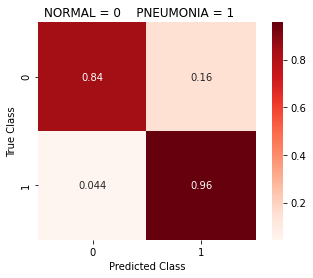

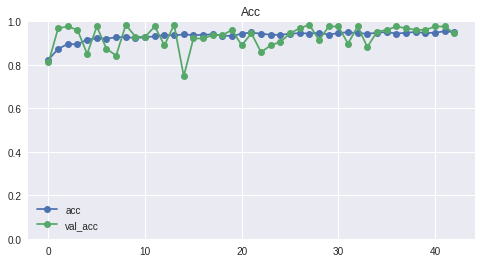

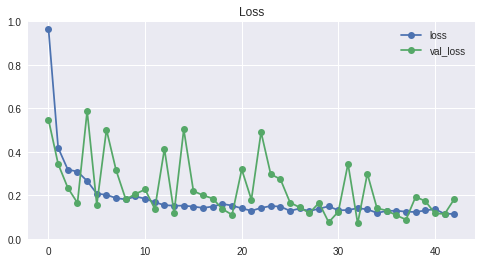

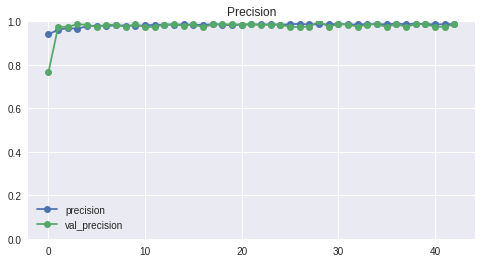

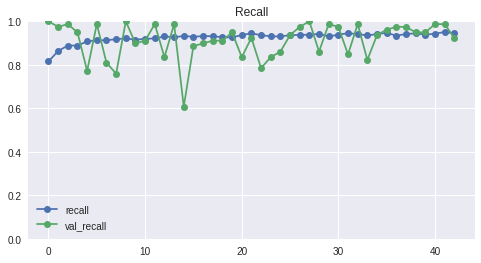

------------------------------------------------------------
16/16 [==============================] - 1s 71ms/step - loss: 0.2690 - acc: 0.9141 - precision: 0.9104 - recall: 0.9561
loss score: 0.2689768373966217
accuracy score: 0.9140625
precision score: 0.9104477763175964
recall score: 0.9561128616333008

Total time to complete: 36.39 minutes


In [ ]:
#USING OUR BIG IMAGES
vgg_cnn = transfer_model(base=vgg_base, alpha=0.3, 
                         opt=optimizers.Adam(learning_rate=0.001))
history_vgg = fit_cnn_gen(vgg_cnn, Xt_train, yt_train, 
                    Xt_val, yt_val, Xt_test, yt_test, 
                    epochs=50, batch_size=32, generator=aug_train_datagen, 
                    class_weights=class_weights_dict, #{0: [1.94, 2, 2], 1:[0.67, 0.6, 0.7]}
                    callbacks=three_callbacks(min_delta=0.001, patience=10, 
                                             save_best_only=True, factor=0.9,
                                             f_path=VGG_PATH, lr_patience=6,
                                             restore_best_weights=True, 
                                             mode='min'))

Filtering through our created VGG-19 models

In [ ]:
source = '/content/drive/MyDrive/gdrive/models/pneumonia_models/vgg_mods224/'
new_dirs = '/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/vgg_224/'
move_best_models(source, Xt_test, yt_test, new_dirs, threshold=0.90)

16/16 [==============================] - 1s 45ms/step - loss: 0.2690 - acc: 0.9141 - precision: 0.9104 - recall: 0.9561
wgt-improv-33-0.07.hdf5


16/16 [==============================] - 1s 44ms/step - loss: 0.2689 - acc: 0.9141 - precision: 0.9104 - recall: 0.9561
---------------------------------------------------------
                  Classification Report

              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88       193
         1.0       0.91      0.96      0.93       319

    accuracy                           0.91       512
   macro avg       0.92      0.90      0.91       512
weighted avg       0.91      0.91      0.91       512

---------------------------------------------------------


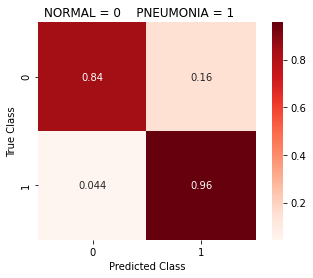

In [ ]:
best_vgg_model1 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/vgg_224/wgt-improv-33-0.07.hdf5')
best_vgg_model1.evaluate(Xt_test, yt_test)
class_report(best_vgg_model1, Xt_test, yt_test)

#### DenseNet121

We can use the same train, test, and val sets as the vgg-19 model because both models can use the 224x224 image sizes.

In [ ]:
INPUT_SHAPE_tf

(224, 224, 3)

In [ ]:
dense_base = DenseNet121(include_top=False, weights='imagenet', 
                          input_shape=INPUT_SHAPE_tf)

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
dense_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
# We will store them in the same folder as our vgg models because they use the 
# same image shape
DENSE_PATH = '/content/drive/MyDrive/gdrive/models/pneumonia_models/dense_mods224/'

In [ ]:
def transfer_model(base, opt=tf.keras.optimizers.Adam(), alpha=0.3,
                          metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')]):

  for layer in base.layers:
    layer.trainable = False

  model = Sequential()
  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(2056))
  model.add(layers.LeakyReLU(alpha=alpha))
  model.add(layers.BatchNormalization())

  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=alpha))
  #model.add(layers.Dropout(0.2))

  model.add(layers.Dense(128))
  model.add(layers.LeakyReLU(alpha=alpha))

  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
  print(model.summary())
  return model

In [ ]:
dense_cnn = transfer_model(base=dense_base, alpha=0.3, 
                         opt=optimizers.Adam(learning_rate=0.001))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2056)              103163912 
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2056)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2056)              8224      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1053184   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)              

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2056)              103163912 
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 2056)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2056)              8224      
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1053184   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)              

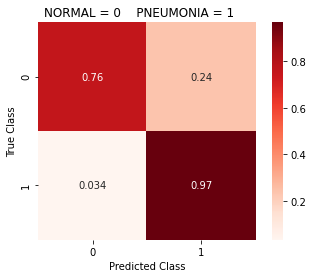

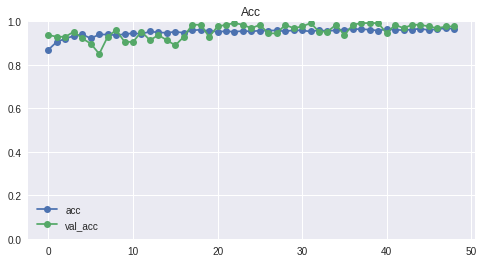

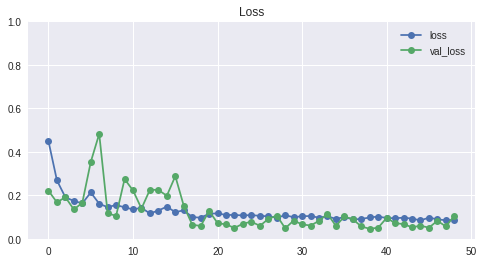

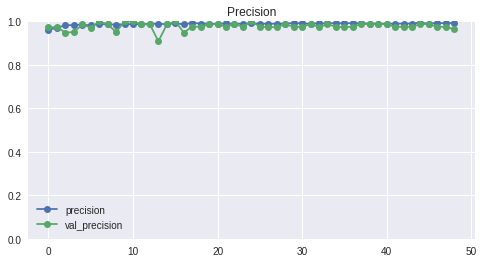

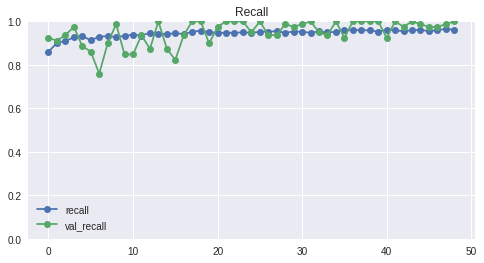

------------------------------------------------------------
16/16 [==============================] - 1s 57ms/step - loss: 0.4421 - acc: 0.8887 - precision: 0.8701 - recall: 0.9655
loss score: 0.4421292245388031
accuracy score: 0.888671875
precision score: 0.8700565099716187
recall score: 0.9655172228813171

Total time to complete: 47.36 minutes


In [ ]:
dense_cnn = transfer_model(base=dense_base, alpha=0.3, 
                         opt=optimizers.Adam(learning_rate=0.001))
history_dense = fit_cnn_gen(dense_cnn, Xt_train, yt_train, 
                    Xt_val, yt_val, Xt_test, yt_test, 
                    epochs=50, batch_size=32, generator=aug_train_datagen, 
                    class_weights=class_weights_dict, #{0: [1.94, 2, 2], 1:[0.67, 0.6, 0.7]}
                    callbacks=three_callbacks(min_delta=0.001, patience=10, 
                                             save_best_only=True, factor=0.9,
                                             f_path=DENSE_PATH, lr_patience=6,
                                             restore_best_weights=True, 
                                             mode='min'))

Filtering through our Dense121 models

In [ ]:
source = '/content/drive/MyDrive/gdrive/models/pneumonia_models/dense_mods224/'
new_dirs = '/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/dense_224/'
move_best_models(source, Xt_test, yt_test, new_dirs, threshold=0.90)

16/16 [==============================] - 1s 57ms/step - loss: 0.2551 - acc: 0.9043 - precision: 0.9383 - recall: 0.9060
wgt-improv-08-0.12.hdf5
16/16 [==============================] - 1s 57ms/step - loss: 0.2601 - acc: 0.9121 - precision: 0.9053 - recall: 0.9592
wgt-improv-23-0.05.hdf5
16/16 [==============================] - 1s 58ms/step - loss: 0.4421 - acc: 0.8887 - precision: 0.8701 - recall: 0.9655


16/16 [==============================] - 1s 58ms/step - loss: 0.2601 - acc: 0.9121 - precision: 0.9053 - recall: 0.9592
---------------------------------------------------------
                  Classification Report

              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88       193
         1.0       0.91      0.96      0.93       319

    accuracy                           0.91       512
   macro avg       0.92      0.90      0.90       512
weighted avg       0.91      0.91      0.91       512

---------------------------------------------------------


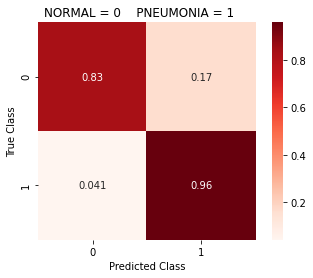

In [ ]:
best_dense_model1 = load_model('/content/drive/MyDrive/gdrive/models/pneumonia_models/best_models/dense_224/wgt-improv-23-0.05.hdf5')
best_dense_model1.evaluate(Xt_test, yt_test)
class_report(best_dense_model1, Xt_test, yt_test)

Our transfer models seemed to get around the same accuracy as our custom models and converged quicker in terms of epochs. However, they took more time to train than our 64x64 models and take up a lot more space in our drive -- about 1GB for each model versus our 64x64 models which take up less than 10MB each. It seems that we are unable to get past 93% accuracy for any of our tests, which could indicate that we have reached the extent of our models' abilities to further differentiate between the classes.

# Interpretation

Image Classification can go many ways depending on what you're looking for or what score you are trying to improve. Our goal was to create a model with an accuracy higher than 90% and a recall greater than 95%. 

In the health field, determining which scoring we want to optimize is based off of the severity of the infection/disease we are looking for. Sensitivity and specificity are measures of recall in positive and negative classes respectively. 

---------------------------------------------------------------
Having a high **sensitivity** (recall for positive class) means that if the result is positive, the patient is more likely to have the infection/disease.    

---------------------------------------------------------------
Whereas having a high **specificity** (recall for negative class) means if the result is negative, the patient is more likely to not have the infection/disease.

---------------------------------------------------------------
No test is perfect however; that would mean the model has perfect recall for both classes == perfect accuracy. Depending on the severity of the infection/disease and the cost for both risk and price of further testing can also be a factor for determing the preferred scoring for screening. 



Setting an appropriate amount for validation data can be extremely beneficial for getting better results on our models. Originally the validation size contained only 16 images, so we merged that set into our test set and then proceeded to split 20% off from our test set to create a new validation set. 

Image augmentation using ImageDataGenerators gives our models more to see when dealing with small datasets. Selecting correct augmentation is also important, we don't want to randomly guess which augmentation without even thinking about it. For instance, our pictures are all greyscaled so it would not make much sense for us to augment images using channel_shift_range. 

Class weights are also extremely beneficial when dealing with unbalanced classes in a dataset. Including the class weights allow us to penalize misclassification of the minority class by setting a higher weight and reducing the weight for the majority class. 


Making Callbacks are (in my opinion) pretty much required when creating models. There are many different types of callbacks to try out, but I feel like Modelcheckpoint and EarlyStopping are essential when training models; allowing us to stop the model before overfitting and saving the best models based on a certain monitored value.

Training models on smaller images significantly decreases training time (about 10 times as fast). If you are pressed for time, decreasing image size will definitely reduce the amount of time it takes for your models to train. 

Transfer Learning models are also great for dealing with smaller datasets. The type of dataset we are working with will determine the transfer model(s) we would want to try out. A transfer model that has never seen chest x-rays would more than likely not perform very well compared to one that has seen chest x-rays. Some downside to transfer models that I have experienced are: 

1. The amount of time it takes to train: Since some models require a certain minimum image size, these models can take a while to train - not as long as our 256x256 custom models, but not as quick as our 64x64 custom models. 
2. The size of the model: These models are huge, and each dense model I've saved so far is about 1GB. To me, that is a lot of space, where my larger custom models are only, at maximum, around 100MB.


### Conclusion

Here are the processes I recommend when it comes to creating a Convolutional Neural Network to Classify Images:

- Augment your training data when working with a small amount of data
- Create and implement class weights if your dataset is unbalanced
- Research and choose which metrics you want to focus on - especially if you are in the health field. Severity and cost of further testing can greatly impact the scoring you want to focus on (Sensitivity vs Specificity)
- Use a smaller image size if you are able to and do not have time to train on bigger images. Keep in mind that reducing pixel size may decrease model performance - however in this project, it did not.
- Add callbacks to prevent overfitting and save best models from each training session.
- Start with a smaller, simpler model and increase complexity as you go; going to an increased complexity may be harder to figure out what you need to change or remove.
- Transfer learning models are powerful tools that you should get comfortable working with - they are very useful IF you choose the right models to train; it will always depend on what data you are working with.

## Further Research
I would like to further investigate more preprocessing strategies for images, specifically using Contrast Limited Adaptive Histogram Equalization (CLAHE) to equalize x-ray images. What CLAHE does is it works on tiles, which are small regions in the image, than the entire image. It then combines neighboring tiles using binary interpolation to remove the artificial boundaries. [3] Removing haze and increasing contrast from the chest x-ray images could definitely provide some benefit if used correctly. This would be a great preprocessing tool to take advantage of once I know more about cv2.

Creating a model that is trained on x-ray images of different age groups would also be beneficial - especially the elderly population. In this project, we were only given x-ray chest images from children 5 years old and under. In the United States, the age group with the highest mortality risk for pneumonia are people 70 years and older. Having a dataset to help diagnose this age group could definitely help in terms of identifying the infection earlier, which would mean earlier treatment, leading to better outcomes, and ultimately lowering the mortality rate[4].

I would also like to create a model that can not only diagnose pneumonia, but also the type of pneumonia (e.g. bacterial, viral, or fungal). However, creating a model like this may need more than solely x-ray images to classify with a high accuracy.

Taking it a step further, creating multiple models to check for certain infections/diseases that typically use x-ray imaging as the golden standard in terms of diagnosing the problem could also be extremely beneficial. There are many different types of infections and diseases that we would be able to help diagnose if trained on the correct dataset(s).  

# Citations


1. Dadonaite, Bernadeta. “Pneumonia.” Our World in Data, 4 Nov. 2018, ourworldindata.org/pneumonia#:%7E:text=2.56%20million%20people%20died%20from,of%20the%20lungs%2C%20called%20alveoli.



2. Hashmi, Mohammad Farukh et al. “Efficient Pneumonia Detection in Chest Xray Images Using Deep Transfer Learning.” Diagnostics (Basel, Switzerland) vol. 10,6 417. 19 Jun. 2020, doi:10.3390/diagnostics10060417

3. “Histograms - 2: Histogram Equalization — OpenCV-Python Tutorials 1 Documentation.” OpenCV Python Tutorials, opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html. 

4. Mody, Lona et al. “Assessment of pneumonia in older adults: effect of functional status.” Journal of the American Geriatrics Society vol. 54,7 (2006): 1062-7. doi:10.1111/j.1532-5415.2006.00797.x
